<a href="https://colab.research.google.com/github/ShewlyMisty/Extreme_Cold_Prey_Predator/blob/main/SPDE_DeepONet_FNO_Combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Cell 0: Setup (imports, device, folders, seeds) ===
import os, json, math, time, random
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from pathlib import Path




import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# --- Matplotlib defaults ---
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.bbox"] = "tight"

# --- Reproducibility & stable CuDNN ---
SEED = 1337  # <- use any fixed integer you like
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # Make CuDNN deterministic and disable autotuner (prevents run-to-run drift)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Prefer float32 everywhere (do this before defining models)
torch.set_default_dtype(torch.float32)

# --- Device & folders ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE.type, end="")
if DEVICE.type == "cuda":
    try:
        print(f" | {torch.cuda.get_device_name(0)}")
    except Exception:
        print()
else:
    print()

OUT_FIG = Path("figures"); OUT_FIG.mkdir(parents=True, exist_ok=True)
DATA_DIR = Path("data_spde"); DATA_DIR.mkdir(parents=True, exist_ok=True)


Device: cuda | NVIDIA A100-SXM4-40GB


In [2]:
# === Cell 1: Chebyshev grid & boundary helper; params; local reactions ===


def cheb_lobatto(N: int):
    """
    Return (D, x) where x are Chebyshev–Lobatto nodes on [-1,1] (descending),
    and D is the Chebyshev first-derivative matrix on those nodes.
    """
    if N == 0:
        return np.array([[0.0]]), np.array([1.0])
    x = np.cos(np.pi * np.arange(N+1) / N)  # descending: x[0]=1 ... x[N]=-1

    # Chebyshev differentiation matrix (Trefethen “Spectral Methods in MATLAB”)
    c = np.ones(N+1); c[0] = 2.0; c[-1] = 2.0
    c = c * ((-1.0) ** np.arange(N+1))
    X  = np.tile(x, (N+1, 1))
    dX = X - X.T + np.eye(N+1)
    D  = (c[:, None] / c[None, :]) / dX
    D  = D - np.diag(np.sum(D, axis=1))

    # Report a positive min Δx using a sorted copy (monotone increasing)
    x_sorted = np.sort(x)
    dx_min = float(np.min(np.diff(x_sorted)))
    print(f"[grid] x in [{x.min():.1f},{x.max():.1f}], min Δx≈{dx_min:.6f}")

    return D, x

def enforce_neumann(u: np.ndarray):
    """Ghost-point style Neumann BC: ∂x u = 0 at both ends ⇒ copy edge-adjacent values."""
    u[0]  = u[1]
    u[-1] = u[-2]
    return u




In [3]:
# === Cell 2: Model parameters & local reactions ===

@dataclass
class SPDEParams:
    a_E: float = 1.0
    sigma_E: float = 0.5
    d_E: float = 1.0
    b: float = 2.0
    # Brownian noise (can later swap to callables via *_fun)
    sigma_u: float = 0.05
    sigma_v: float = 0.05
    # Jump (compound Poisson) rates & scales
    lambda_jump_u: float = 0.12
    lambda_jump_v: float = 0.12
    jump_scale_u: float = 0.04
    jump_scale_v: float = 0.04
    # Safety clipping for states (keep moderate)
    clip_val: float = 5.0
    # Optional callables; keep as plain objects to avoid typing issues on older Python
    sigma_u_fun: object = None
    sigma_v_fun: object = None
    jump_u_fun:  object = None
    jump_v_fun:  object = None

def f_react(u, v, a_E):
    # prey (u) local reaction
    return -a_E*u + (1 + a_E)*u**2 - u**3 - u*v

def g_react(u, v, b, sigma_E, d_E):
    # predator (v) local reaction
    return b*u*v - sigma_E*v - d_E*v**3

In [4]:
# # === Cell 3: Simulator (IMEX) ===
# PARAMS_VERSION = "v1.1-imex-cheb-neumann"  # for dataset provenance

# class PredatorPreySPDE:
#     def __init__(self, N=32, L=1.0, dt=2e-3, T=0.4, params: SPDEParams=SPDEParams(), seed=123):
#         self.N = N; self.L = L; self.dt = dt; self.T = T; self.params = params
#         if seed is not None:
#             np.random.seed(seed)

#         D, x_ref = cheb_lobatto(N)
#         self.x_ref = x_ref                    # Chebyshev–Lobatto nodes in [-1,1]
#         self.x     = L * x_ref                # physical coordinates
#         self.D     = D
#         self.D2    = (D @ D) / (L**2)         # Laplacian (Neumann via ghost/equality rows)
#         self.steps = int(np.round(T/dt))
#         self.t     = np.linspace(0.0, self.steps*dt, self.steps+1)

#     def _sigma_u(self, x, t, u):
#         return self.params.sigma_u_fun(x,t,u) if self.params.sigma_u_fun else self.params.sigma_u

#     def _sigma_v(self, x, t, v):
#         return self.params.sigma_v_fun(x,t,v) if self.params.sigma_v_fun else self.params.sigma_v

#     def _jump_u_scale(self, x, t, u):
#         return self.params.jump_u_fun(x,t,u) if self.params.jump_u_fun else self.params.jump_scale_u

#     def _jump_v_scale(self, x, t, v):
#         return self.params.jump_v_fun(x,t,v) if self.params.jump_v_fun else self.params.jump_scale_v

#     def simulate_imex(self, u0=None, v0=None, return_noise=True):
#         N, dt, p = self.N, self.dt, self.params

#         # smooth localized + small oscillation defaults
#         if u0 is None:
#             u = 0.15*np.exp(-4.0*self.x_ref**2) + 0.03*np.cos(2*np.pi*(self.x_ref+0.25))
#         else:
#             u = np.asarray(u0).copy()
#         if v0 is None:
#             v = 0.10*np.exp(-6.0*(self.x_ref-0.2)**2) + 0.02*np.cos(2*np.pi*(self.x_ref-0.3))
#         else:
#             v = np.asarray(v0).copy()

#         U = np.zeros((self.steps+1, N+1)); U[0] = u
#         V = np.zeros_like(U);              V[0] = v
#         W1 = np.zeros_like(U); W2 = np.zeros_like(U)
#         J1 = np.zeros_like(U); J2 = np.zeros_like(U)

#         I = np.eye(N+1); A = self.D2
#         LHS = (I - dt*A)  # IMEX: implicit diffusion, explicit reaction+noise+jumps

#         for n in range(self.steps):
#             # reactions
#             fu = f_react(u, v, p.a_E)
#             gv = g_react(u, v, p.b, p.sigma_E, p.d_E)

#             # Brownian increments (multiplicative)
#             dW_u = np.sqrt(dt) * np.random.randn(N+1)
#             dW_v = np.sqrt(dt) * np.random.randn(N+1)
#             sig_u = self._sigma_u(self.x, self.t[n], u)
#             sig_v = self._sigma_v(self.x, self.t[n], v)

#             # Lévy jumps (compound Poisson, multiplicative shot noise)
#             Ju = np.zeros_like(u); Jv = np.zeros_like(v)
#             if np.random.rand() < p.lambda_jump_u*dt:
#                 alpha_u = self._jump_u_scale(self.x, self.t[n], u)
#                 Ju = u * (alpha_u * np.random.randn(N+1))
#             if np.random.rand() < p.lambda_jump_v*dt:
#                 alpha_v = self._jump_v_scale(self.x, self.t[n], v)
#                 Jv = v * (alpha_v * np.random.randn(N+1))

#             # IMEX step
#             rhs_u = u + dt*fu + sig_u*dW_u + Ju
#             rhs_v = v + dt*gv + sig_v*dW_v + Jv

#             u = np.linalg.solve(LHS, rhs_u)
#             v = np.linalg.solve(LHS, rhs_v)

#             # Neumann & soft clipping
#             u = enforce_neumann(u); v = enforce_neumann(v)
#             # --- pre-clip diagnostics ---
#             umax = float(np.nanmax(np.abs(u)))
#             vmax = float(np.nanmax(np.abs(v)))
#             if umax > 1e3 or vmax > 1e3:  # threshold you consider unphysical
#                 print(f"[WARN] pre-clip blow-up at step {n}: ||u||inf≈{umax:.2e}, ||v||inf≈{vmax:.2e}")

#             u = np.clip(u, -p.clip_val, p.clip_val)
#             v = np.clip(v, -p.clip_val, p.clip_val)

#             # record
#             U[n+1] = u; V[n+1] = v
#             W1[n+1] = dW_u; W2[n+1] = dW_v
#             J1[n+1] = Ju;   J2[n+1] = Jv

#         if return_noise:
#             return self.x, self.t, U, V, W1, W2, J1, J2
#         else:
#             return self.x, self.t, U, V


In [7]:
# # === Cell 3: Simulator (IMEX) — ultra-robust version (taming + substeps + backtracking + smoothing) ===
# PARAMS_VERSION = "v1.4-imex-cheb-neumann-ultra"

# class PredatorPreySPDE:
#     def __init__(self, N=32, L=1.0, dt=2e-3, T=0.4, params: SPDEParams=SPDEParams(), seed=123):
#         self.N = N; self.L = L; self.dt = dt; self.T = T; self.params = params
#         if seed is not None:
#             np.random.seed(seed)
#         D, x_ref = cheb_lobatto(N)
#         self.x_ref = x_ref
#         self.x     = L * x_ref
#         self.D     = D
#         self.D2    = (D @ D) / (L**2)
#         self.steps = int(np.round(T/dt))
#         self.t     = np.linspace(0.0, self.steps*dt, self.steps+1)

#     def _sigma_u(self, x, t, u):
#         return self.params.sigma_u_fun(x,t,u) if self.params.sigma_u_fun else self.params.sigma_u
#     def _sigma_v(self, x, t, v):
#         return self.params.sigma_v_fun(x,t,v) if self.params.sigma_v_fun else self.params.sigma_v
#     def _jump_u_scale(self, x, t, u):
#         return self.params.jump_u_fun(x,t,u) if self.params.jump_u_fun else self.params.jump_scale_u
#     def _jump_v_scale(self, x, t, v):
#         return self.params.jump_v_fun(x,t,v) if self.params.jump_v_fun else self.params.jump_scale_v


#     def simulate_imex(
#         self, u0=None, v0=None, return_noise=True,
#         # stronger defaults
#         k_sub=10,                  # more microsteps stabilizes explicit part
#         tame_type="poly",         # polynomial taming
#         tame_alpha=1.5,           # stronger taming (try 0.8–2.0)
#         jump_clip_factor=1.0,     # tighter jump bounds
#         sigma_cap=0.08,           # cap multiplicative noise coeffs
#         drift_cap=3.0,            # cap |f_react|, |g_react| (elementwise)
#         explode_thresh=3.0,      # accept/reject threshold for trial step
#         max_backtracks=8,         # more retries on spike
#         # smoothing (cheap "spectral viscosity" via Laplacian solve)
#         micro_eps=1e-2,           # small smoothing per microstep
#         post_eps=2e-2             # smoothing after implicit diffusion
#     ):
#         """
#         IMEX: implicit diffusion (full dt), explicit reactions+noise+jumps (k_sub microsteps).
#         Hardening features: polynomial taming, drift capping, adaptive microstep backtracking,
#         sigma/jump capping, & tiny Laplacian smoothing (no FFT needed).
#         """
#         N, dt, p = self.N, self.dt, self.params
#         I = np.eye(N+1);
#         # Chebyshev second-derivative matrix you built in __init__ is self.D2
#         # For diffusion we must use A = -D2 (Neumann Laplacian is negative-semi-definite)
#         A = -self.D2
#         # A = self.D2

#         eps_mass = 1e-6  # tiny Tikhonov regularizer
#         LHS_diff         = (I - dt*A)         + eps_mass*I   # == I + dt*D2 + eps*I
#         LHS_smooth_micro = (I -  micro_eps*A)               # == I + micro_eps*D2
#         LHS_smooth_post  = (I -   post_eps*A)               # == I + post_eps*D2

#         # (Optional sanity check)
#         cond_u = np.linalg.cond(LHS_diff)
#         print(f"[diff] cond(I - dt*A) ≈ {cond_u:.3e}")

#         # eps_mass = 1e-6   # tiny Tikhonov regularizer for well-conditioning
#         # LHS_diff = (np.eye(N+1) - dt*A) + eps_mass*np.eye(N+1)
#         # LHS_smooth_micro = (I - micro_eps*A)  # micro-smoother
#         # LHS_smooth_post  = (I - post_eps*A)   # post-diffusion smoother

#         # defaults
#         if u0 is None:
#             u = 0.15*np.exp(-4.0*self.x_ref**2) + 0.03*np.cos(2*np.pi*(self.x_ref+0.25))
#         else:
#             u = np.asarray(u0, dtype=float).copy()
#         if v0 is None:
#             v = 0.10*np.exp(-6.0*(self.x_ref-0.2)**2) + 0.02*np.cos(2*np.pi*(self.x_ref-0.3))
#         else:
#             v = np.asarray(v0, dtype=float).copy()

#         U = np.zeros((self.steps+1, N+1)); U[0] = u
#         V = np.zeros_like(U);              V[0] = v
#         W1 = np.zeros_like(U); W2 = np.zeros_like(U)
#         J1 = np.zeros_like(U); J2 = np.zeros_like(U)

#         k_sub = int(max(1, k_sub))
#         h_base = dt / k_sub

#         for n in range(self.steps):
#             t_n = self.t[n]
#             dW_u_acc = np.zeros(N+1); dW_v_acc = np.zeros(N+1)
#             J_u_acc  = np.zeros(N+1); J_v_acc  = np.zeros(N+1)

#             u_exp = u.copy(); v_exp = v.copy()
#             for _ in range(k_sub):
#                 h_eff = h_base
#                 for _bt in range(max_backtracks+1):
#                     fu = f_react(u_exp, v_exp, p.a_E)
#                     gv = g_react(u_exp, v_exp, p.b, p.sigma_E, p.d_E)

#                     # drift capping
#                     fu = np.clip(fu, -drift_cap, drift_cap)
#                     gv = np.clip(gv, -drift_cap, drift_cap)

#                     # polynomial taming
#                     if tame_type == "poly":
#                         den = 1.0 + tame_alpha * h_eff * (u_exp*u_exp + v_exp*v_exp)
#                         fu /= den; gv /= den
#                     elif tame_type == "linear":
#                         den = 1.0 + tame_alpha * h_eff * (np.abs(u_exp) + np.abs(v_exp))
#                         fu /= den; gv /= den
#                     # else: None

#                     # multiplicative Brownian with caps
#                     sig_u = np.clip(self._sigma_u(self.x, t_n, u_exp), -sigma_cap, sigma_cap)
#                     sig_v = np.clip(self._sigma_v(self.x, t_n, v_exp), -sigma_cap, sigma_cap)
#                     dW_u = np.sqrt(h_eff) * np.random.randn(N+1)
#                     dW_v = np.sqrt(h_eff) * np.random.randn(N+1)

#                     # compound Poisson jumps
#                     Ju = np.zeros_like(u_exp); Jv = np.zeros_like(v_exp)
#                     nJ_u = np.random.poisson(p.lambda_jump_u * h_eff)
#                     nJ_v = np.random.poisson(p.lambda_jump_v * h_eff)
#                     if nJ_u > 0:
#                         scale_u = self._jump_u_scale(self.x, t_n, u_exp)
#                         Ju = scale_u * np.random.randn(N+1) * np.sqrt(max(1, nJ_u))
#                     if nJ_v > 0:
#                         scale_v = self._jump_v_scale(self.x, t_n, v_exp)
#                         Jv = scale_v * np.random.randn(N+1) * np.sqrt(max(1, nJ_v))
#                     # if nJ_u > 0:
#                     #     scale_u = self._jump_u_scale(self.x, t_n, u_exp)
#                     #     Ju = u_exp * (scale_u * np.random.randn(N+1) * nJ_u)
#                     # if nJ_v > 0:
#                     #     scale_v = self._jump_v_scale(self.x, t_n, v_exp)
#                     #     Jv = v_exp * (scale_v * np.random.randn(N+1) * nJ_v)
#                     if jump_clip_factor is not None:
#                         if nJ_u > 0:
#                             Ju = np.clip(Ju, -jump_clip_factor*scale_u*(1.0+np.abs(u_exp)),
#                                               jump_clip_factor*scale_u*(1.0+np.abs(u_exp)))
#                         if nJ_v > 0:
#                             Jv = np.clip(Jv, -jump_clip_factor*scale_v*(1.0+np.abs(v_exp)),
#                                               jump_clip_factor*scale_v*(1.0+np.abs(v_exp)))

#                     # trial explicit step
#                     u_trial = u_exp + h_eff*fu + sig_u*dW_u + Ju
#                     v_trial = v_exp + h_eff*gv + sig_v*dW_v + Jv

#                     # accept / backtrack
#                     if (np.max(np.abs(u_trial)) <= explode_thresh) and (np.max(np.abs(v_trial)) <= explode_thresh):
#                         # micro-smoothing before accepting (cheap high-mode damping)
#                         u_trial = np.linalg.solve(LHS_smooth_micro, u_trial)
#                         v_trial = np.linalg.solve(LHS_smooth_micro, v_trial)

#                         u_exp = enforce_neumann(u_trial)
#                         v_exp = enforce_neumann(v_trial)
#                         dW_u_acc += dW_u; dW_v_acc += dW_v
#                         J_u_acc  += Ju;   J_v_acc  += Jv
#                         break
#                     else:
#                         h_eff *= 0.5
#                         if _bt == max_backtracks:
#                             # last resort: clamp and move on
#                             u_trial = np.clip(u_trial, -explode_thresh, explode_thresh)
#                             v_trial = np.clip(v_trial, -explode_thresh, explode_thresh)
#                             u_trial = np.linalg.solve(LHS_smooth_micro, u_trial)
#                             v_trial = np.linalg.solve(LHS_smooth_micro, v_trial)
#                             u_exp = enforce_neumann(u_trial)
#                             v_exp = enforce_neumann(v_trial)
#                             dW_u_acc += dW_u; dW_v_acc += dW_v
#                             J_u_acc  += Ju;   J_v_acc  += Jv

#             # implicit diffusion over full dt
#             u = np.linalg.solve(LHS_diff, u_exp)
#             v = np.linalg.solve(LHS_diff, v_exp)

#             # post-step smoothing
#             u = np.linalg.solve(LHS_smooth_post, u)
#             v = np.linalg.solve(LHS_smooth_post, v)

#             # enforce Neumann again (also stabilizes edges)
#             u = enforce_neumann(u)
#             v = enforce_neumann(v)

#             # # implicit diffusion over full dt
#             # u = np.linalg.solve(LHS_diff, u_exp)
#             # v = np.linalg.solve(LHS_diff, v_exp)

#             # # post-step smoothing
#             # u = np.linalg.solve(LHS_smooth_post, u)
#             # v = np.linalg.solve(LHS_smooth_post, v)

#             # diagnostics (should now be very rare)
#             umax = float(np.nanmax(np.abs(u))); vmax = float(np.nanmax(np.abs(v)))
#             if umax > 1e3 or vmax > 1e3:
#                 print(f"[WARN] pre-clip blow-up at step {n}: ||u||inf≈{umax:.2e}, ||v||inf≈{vmax:.2e}")

#             # final soft clip
#             u = np.clip(u, -p.clip_val, p.clip_val)
#             v = np.clip(v, -p.clip_val, p.clip_val)

#             U[n+1]  = u;     V[n+1]  = v
#             W1[n+1] = dW_u_acc; W2[n+1] = dW_v_acc
#             J1[n+1] = J_u_acc;  J2[n+1] = J_v_acc

#         if return_noise:
#             return self.x, self.t, U, V, W1, W2, J1, J2
#         else:
#             return self.x, self.t, U, V


In [15]:
# # === Cell 3: Simulator (IMEX) — ultra-robust (taming + substeps + backtracking + smoothing) ===
# PARAMS_VERSION = "v1.5-imex-cheb-neumann-ultra-spd"
# # Put this near the top of Cell 3 (module-level)
# _GLOBAL_CONDS_PRINTED = False

# class PredatorPreySPDE:
#     def __init__(self, N=32, L=1.0, dt=2e-3, T=0.4, params: SPDEParams=SPDEParams(), seed=123):
#         self.N = N; self.L = L; self.dt = dt; self.T = T; self.params = params
#         if seed is not None:
#             np.random.seed(seed)
#         D, x_ref = cheb_lobatto(N)
#         self.x_ref = x_ref
#         self.x     = L * x_ref
#         self.D     = D
#         self.D2    = (D @ D) / (L**2)         # raw Chebyshev second-derivative (dense)
#         self.steps = int(np.round(T/dt))
#         self.t     = np.linspace(0.0, self.steps*dt, self.steps+1)

#     def _sigma_u(self, x, t, u):
#         return self.params.sigma_u_fun(x,t,u) if self.params.sigma_u_fun else self.params.sigma_u
#     def _sigma_v(self, x, t, v):
#         return self.params.sigma_v_fun(x,t,v) if self.params.sigma_v_fun else self.params.sigma_v
#     def _jump_u_scale(self, x, t, u):
#         return self.params.jump_u_fun(x,t,u) if self.params.jump_u_fun else self.params.jump_scale_u
#     def _jump_v_scale(self, x, t, v):
#         return self.params.jump_v_fun(x,t,v) if self.params.jump_v_fun else self.params.jump_scale_v

#     def simulate_imex(
#         self, u0=None, v0=None, return_noise=True,
#         # stability-first defaults
#         k_sub=12,                 # a touch more substeps further damps the explicit part
#         tame_type="poly",
#         tame_alpha=1.5,
#         jump_clip_factor=1.0,     # additive jumps → clip to ±scale
#         sigma_cap=0.08,
#         drift_cap=3.0,
#         explode_thresh=2.5,       # catch spikes early
#         max_backtracks=10,
#         # Laplacian-based smoothers
#         micro_eps=2e-2,           # stronger micro smoothing
#         post_eps=3e-2             # stronger post smoothing
#     ):
#         """
#         IMEX: implicit diffusion (full dt), explicit reactions+noise+jumps (k_sub microsteps).
#         Robustness: SPD diffusion (symmetrized D2), Tikhonov regularization, taming/caps, backtracking,
#         and small Laplacian smoothers.
#         """
#         N, dt, p = self.N, self.dt, self.params
#         I = np.eye(N+1)

#         # --- Symmetrize the second derivative to ensure SPD operator ---
#         D2s = 0.5 * (self.D2 + self.D2.T)   # symmetric part of D2
#         A   = -D2s                           # Neumann Laplacian sign convention

#         # --- Linear systems; slightly stronger Tikhonov on the main implicit solve ---
#         eps_mass = 1e-3
#         LHS_diff         = (I - dt*A)         + eps_mass*I
#         LHS_smooth_micro = (I -  micro_eps*A)
#         LHS_smooth_post  = (I -   post_eps*A)

#         # # --- One-time diagnostics ---
#         # if not hasattr(self, "_printed_cond"):
#         #     print(f"[diff]  cond(I - dt*A)      ≈ {np.linalg.cond(LHS_diff):.3e}")
#         #     self._printed_cond = True
#         # if not hasattr(self, "_printed_smooth_conds"):
#         #     print(f"[micro] cond(I - micro*A)   ≈ {np.linalg.cond(LHS_smooth_micro):.3e}")
#         #     print(f"[post ] cond(I - post*A)    ≈ {np.linalg.cond(LHS_smooth_post):.3e}")
#         #     self._printed_smooth_conds = True
#         # --- Global one-time diagnostics (print only once per script run) ---
#         global _GLOBAL_CONDS_PRINTED
#         if not _GLOBAL_CONDS_PRINTED:
#             print(f"[diff]  cond(I - dt*A)      ≈ {np.linalg.cond(LHS_diff):.3e}")
#             print(f"[micro] cond(I - micro*A)   ≈ {np.linalg.cond(LHS_smooth_micro):.3e}")
#             print(f"[post ] cond(I - post*A)    ≈ {np.linalg.cond(LHS_smooth_post):.3e}")
#             _GLOBAL_CONDS_PRINTED = True


#         # --- defaults / initial conditions ---
#         if u0 is None:
#             #u = 0.15*np.exp(-4.0*self.x_ref**2) + 0.03*np.cos(2*np.pi*(self.x_ref+0.25))
#             u = 0.08*np.exp(-4.0*self.x_ref**2) + 0.015*np.cos(2*np.pi*(self.x_ref+0.25))
#         else:
#             u = np.asarray(u0, dtype=float).copy()
#         if v0 is None:
#             #v = 0.10*np.exp(-6.0*(self.x_ref-0.2)**2) + 0.02*np.cos(2*np.pi*(self.x_ref-0.3))
#             v = 0.06*np.exp(-6.0*(self.x_ref-0.2)**2) + 0.010*np.cos(2*np.pi*(self.x_ref-0.3))

#         else:
#             v = np.asarray(v0, dtype=float).copy()



#         # enforce Neumann on ICs (harmless, a bit safer)
#         u = enforce_neumann(u); v = enforce_neumann(v)

#         U = np.zeros((self.steps+1, N+1)); U[0] = u
#         V = np.zeros_like(U);              V[0] = v
#         W1 = np.zeros_like(U); W2 = np.zeros_like(U)
#         J1 = np.zeros_like(U); J2 = np.zeros_like(U)

#         k_sub = int(max(1, k_sub))
#         h_base = dt / k_sub

#         for n in range(self.steps):
#             t_n = self.t[n]
#             dW_u_acc = np.zeros(N+1); dW_v_acc = np.zeros(N+1)
#             J_u_acc  = np.zeros(N+1); J_v_acc  = np.zeros(N+1)

#             u_exp = u.copy(); v_exp = v.copy()
#             for _ in range(k_sub):
#                 h_eff = h_base
#                 for _bt in range(max_backtracks+1):
#                     # local reactions (capped)
#                     fu = f_react(u_exp, v_exp, p.a_E)
#                     gv = g_react(u_exp, v_exp, p.b, p.sigma_E, p.d_E)
#                     fu = np.clip(fu, -drift_cap, drift_cap)
#                     gv = np.clip(gv, -drift_cap, drift_cap)

#                     # taming
#                     if tame_type == "poly":
#                         den = 1.0 + tame_alpha * h_eff * (u_exp*u_exp + v_exp*v_exp)
#                         fu /= den; gv /= den
#                     elif tame_type == "linear":
#                         den = 1.0 + tame_alpha * h_eff * (np.abs(u_exp) + np.abs(v_exp))
#                         fu /= den; gv /= den

#                     # capped multiplicative Brownian
#                     sig_u = np.clip(self._sigma_u(self.x, t_n, u_exp), -sigma_cap, sigma_cap)
#                     sig_v = np.clip(self._sigma_v(self.x, t_n, v_exp), -sigma_cap, sigma_cap)
#                     dW_u = np.sqrt(h_eff) * np.random.randn(N+1)
#                     dW_v = np.sqrt(h_eff) * np.random.randn(N+1)

#                     # compound Poisson — ADDITIVE jumps (clip to ±scale)
#                     Ju = np.zeros_like(u_exp); Jv = np.zeros_like(v_exp)
#                     nJ_u = np.random.poisson(p.lambda_jump_u * h_eff)
#                     nJ_v = np.random.poisson(p.lambda_jump_v * h_eff)
#                     if nJ_u > 0:
#                         scale_u = self._jump_u_scale(self.x, t_n, u_exp)
#                         Ju = scale_u * np.random.randn(N+1) * np.sqrt(max(1, nJ_u))
#                         if jump_clip_factor is not None:
#                             Ju = np.clip(Ju, -jump_clip_factor*scale_u, jump_clip_factor*scale_u)
#                     if nJ_v > 0:
#                         scale_v = self._jump_v_scale(self.x, t_n, v_exp)
#                         Jv = scale_v * np.random.randn(N+1) * np.sqrt(max(1, nJ_v))
#                         if jump_clip_factor is not None:
#                             Jv = np.clip(Jv, -jump_clip_factor*scale_v, jump_clip_factor*scale_v)

#                     # trial explicit step
#                     u_trial = u_exp + h_eff*fu + sig_u*dW_u + Ju
#                     v_trial = v_exp + h_eff*gv + sig_v*dW_v + Jv

#                     # accept / backtrack
#                     if (np.max(np.abs(u_trial)) <= explode_thresh) and (np.max(np.abs(v_trial)) <= explode_thresh):
#                         # micro-smoothing before accepting
#                         u_trial = np.linalg.solve(LHS_smooth_micro, u_trial)
#                         v_trial = np.linalg.solve(LHS_smooth_micro, v_trial)
#                         u_exp = enforce_neumann(u_trial)
#                         v_exp = enforce_neumann(v_trial)
#                         dW_u_acc += dW_u; dW_v_acc += dW_v
#                         J_u_acc  += Ju;   J_v_acc  += Jv
#                         break
#                     else:
#                         h_eff *= 0.5
#                         if _bt == max_backtracks:
#                             # last resort: clamp + smooth + accept
#                             u_trial = np.clip(u_trial, -explode_thresh, explode_thresh)
#                             v_trial = np.clip(v_trial, -explode_thresh, explode_thresh)
#                             u_trial = np.linalg.solve(LHS_smooth_micro, u_trial)
#                             v_trial = np.linalg.solve(LHS_smooth_micro, v_trial)
#                             u_exp = enforce_neumann(u_trial)
#                             v_exp = enforce_neumann(v_trial)
#                             dW_u_acc += dW_u; dW_v_acc += dW_v
#                             J_u_acc  += Ju;   J_v_acc  += Jv

#             # implicit diffusion over full dt (SPD system)
#             u = np.linalg.solve(LHS_diff, u_exp)
#             v = np.linalg.solve(LHS_diff, v_exp)

#             # post-step smoothing
#             u = np.linalg.solve(LHS_smooth_post, u)
#             v = np.linalg.solve(LHS_smooth_post, v)

#             # re-enforce Neumann after linear solves
#             u = enforce_neumann(u)
#             v = enforce_neumann(v)

#             # diagnostics (should now be very rare and modest)
#             umax = float(np.nanmax(np.abs(u))); vmax = float(np.nanmax(np.abs(v)))
#             if umax > 1e3 or vmax > 1e3:
#                 print(f"[WARN] pre-clip blow-up at step {n}: ||u||inf≈{umax:.2e}, ||v||inf≈{vmax:.2e}")

#             # # final soft clip
#             # u = np.clip(u, -p.clip_val, p.clip_val)
#             # v = np.clip(v, -p.clip_val, p.clip_val)

#             # # final soft clip (optional)
#             # if (getattr(p, "clip_val", None) is not None) and np.isfinite(p.clip_val):
#             #     u = np.clip(u, -p.clip_val, p.clip_val)
#             #     v = np.clip(v, -p.clip_val, p.clip_val)

#             # --- final soft clip (only if a finite clip_val is provided) ---
#             cv = getattr(p, "clip_val", None)
#             if (cv is not None) and np.isfinite(cv):
#                 u = np.clip(u, -cv, cv)
#                 v = np.clip(v, -cv, cv)



#             U[n+1]  = u;     V[n+1]  = v
#             W1[n+1] = dW_u_acc; W2[n+1] = dW_v_acc
#             J1[n+1] = J_u_acc;  J2[n+1] = J_v_acc

#         if return_noise:
#             return self.x, self.t, U, V, W1, W2, J1, J2
#         else:
#             return self.x, self.t, U, V


In [22]:
# === Cell 3: Simulator (IMEX) — ultra-robust (taming + substeps + backtracking + smoothing) ===
PARAMS_VERSION = "v1.5-imex-cheb-neumann-ultra-spd"
# One-time diagnostics gate
_GLOBAL_CONDS_PRINTED = False

class PredatorPreySPDE:
    def __init__(self, N=32, L=1.0, dt=2e-3, T=0.4, params: SPDEParams=SPDEParams(), seed=123):
        self.N = N; self.L = L; self.dt = dt; self.T = T; self.params = params
        if seed is not None:
            np.random.seed(seed)
        D, x_ref = cheb_lobatto(N)
        self.x_ref = x_ref
        self.x     = L * x_ref
        self.D     = D
        self.D2    = (D @ D) / (L**2)         # raw Chebyshev second-derivative (dense)
        self.steps = int(np.round(T/dt))
        self.t     = np.linspace(0.0, self.steps*dt, self.steps+1)

    def _sigma_u(self, x, t, u):
        return self.params.sigma_u_fun(x,t,u) if self.params.sigma_u_fun else self.params.sigma_u
    def _sigma_v(self, x, t, v):
        return self.params.sigma_v_fun(x,t,v) if self.params.sigma_v_fun else self.params.sigma_v
    def _jump_u_scale(self, x, t, u):
        return self.params.jump_u_fun(x,t,u) if self.params.jump_u_fun else self.params.jump_scale_u
    def _jump_v_scale(self, x, t, v):
        return self.params.jump_v_fun(x,t,v) if self.params.jump_v_fun else self.params.jump_scale_v

    def simulate_imex(
        self, u0=None, v0=None, return_noise=True,
        # stability-first defaults
        k_sub=12,
        tame_type="poly",
        tame_alpha=1.5,
        jump_clip_factor=1.0,     # additive jumps → clip to ±scale
        sigma_cap=0.08,
        drift_cap=3.0,
        explode_thresh=2.5,
        max_backtracks=10,
        # Laplacian-based smoothers
        micro_eps=2e-2,
        post_eps=3e-2,
        # NEW: global reaction scaling (0 → off, 1 → full strength)
        react_scale=0.50,
    ):
        """
        IMEX: implicit diffusion (full dt), explicit reactions+noise+jumps (k_sub microsteps).
        Robustness: SPD diffusion (symmetrized D2), Tikhonov regularization, taming/caps, backtracking,
        and small Laplacian smoothers.
        """
        N, dt, p = self.N, self.dt, self.params
        I = np.eye(N+1)

        # --- Symmetrize the second derivative to ensure SPD operator ---
        D2s = 0.5 * (self.D2 + self.D2.T)   # symmetric part of D2
        A   = -D2s                           # Neumann Laplacian sign convention

        # --- Linear systems; slightly stronger Tikhonov on the main implicit solve ---
        eps_mass = 1e-3
        LHS_diff         = (I - dt*A)         + eps_mass*I
        LHS_smooth_micro = (I -  micro_eps*A)
        LHS_smooth_post  = (I -   post_eps*A)

        # --- Global one-time diagnostics (print only once per script run) ---
        global _GLOBAL_CONDS_PRINTED
        if not _GLOBAL_CONDS_PRINTED:
            print(f"[diff]  cond(I - dt*A)      ≈ {np.linalg.cond(LHS_diff):.3e}")
            print(f"[micro] cond(I - micro*A)   ≈ {np.linalg.cond(LHS_smooth_micro):.3e}")
            print(f"[post ] cond(I - post*A)    ≈ {np.linalg.cond(LHS_smooth_post):.3e}")
            _GLOBAL_CONDS_PRINTED = True

        # --- defaults / initial conditions ---
        if u0 is None:
            # u = 0.08*np.exp(-4.0*self.x_ref**2) + 0.015*np.cos(2*np.pi*(self.x_ref+0.25))
            u = 0.08*np.exp(-4.0*self.x_ref**2) + 0.010*np.cos(2*np.pi*(self.x_ref+0.25))
        else:
            u = np.asarray(u0, dtype=float).copy()
        if v0 is None:
            # v = 0.06*np.exp(-6.0*(self.x_ref-0.2)**2) + 0.010*np.cos(2*np.pi*(self.x_ref-0.3))
            v = 0.06*np.exp(-6.0*(self.x_ref-0.2)**2) + 0.008*np.cos(2*np.pi*(self.x_ref-0.3))
        else:
            v = np.asarray(v0, dtype=float).copy()

#             if u0 is None:
# #     u = 0.08*np.exp(-4.0*self.x_ref**2) + 0.010*np.cos(2*np.pi*(self.x_ref+0.25))  # was 0.015
# # if v0 is None:
# #     v = 0.06*np.exp(-6.0*(self.x_ref-0.2)**2) + 0.008*np.cos(2*np.pi*(self.x_ref-0.3)) # was 0.010


        # enforce Neumann on ICs (harmless, a bit safer)
        u = enforce_neumann(u); v = enforce_neumann(v)

        U = np.zeros((self.steps+1, N+1)); U[0] = u
        V = np.zeros_like(U);              V[0] = v
        W1 = np.zeros_like(U); W2 = np.zeros_like(U)
        J1 = np.zeros_like(U); J2 = np.zeros_like(U)

        k_sub = int(max(1, k_sub))
        h_base = dt / k_sub

        for n in range(self.steps):
            t_n = self.t[n]
            dW_u_acc = np.zeros(N+1); dW_v_acc = np.zeros(N+1)
            J_u_acc  = np.zeros(N+1); J_v_acc  = np.zeros(N+1)

            u_exp = u.copy(); v_exp = v.copy()
            for _ in range(k_sub):
                h_eff = h_base
                for _bt in range(max_backtracks+1):
                    # --- local reactions ---
                    fu = f_react(u_exp, v_exp, p.a_E)
                    gv = g_react(u_exp, v_exp, p.b, p.sigma_E, p.d_E)

                    # NEW: scale reactions globally (most effective lever)
                    fu *= react_scale
                    gv *= react_scale

                    # cap the drift (after scaling)
                    fu = np.clip(fu, -drift_cap, drift_cap)
                    gv = np.clip(gv, -drift_cap, drift_cap)

                    # taming
                    if tame_type == "poly":
                        den = 1.0 + tame_alpha * h_eff * (u_exp*u_exp + v_exp*v_exp)
                        fu /= den; gv /= den
                    elif tame_type == "linear":
                        den = 1.0 + tame_alpha * h_eff * (np.abs(u_exp) + np.abs(v_exp))
                        fu /= den; gv /= den

                    # capped multiplicative Brownian
                    sig_u = np.clip(self._sigma_u(self.x, t_n, u_exp), -sigma_cap, sigma_cap)
                    sig_v = np.clip(self._sigma_v(self.x, t_n, v_exp), -sigma_cap, sigma_cap)
                    dW_u = np.sqrt(h_eff) * np.random.randn(N+1)
                    dW_v = np.sqrt(h_eff) * np.random.randn(N+1)

                    # compound Poisson — ADDITIVE jumps (clip to ±scale)
                    Ju = np.zeros_like(u_exp); Jv = np.zeros_like(v_exp)
                    nJ_u = np.random.poisson(p.lambda_jump_u * h_eff)
                    nJ_v = np.random.poisson(p.lambda_jump_v * h_eff)
                    if nJ_u > 0:
                        scale_u = self._jump_u_scale(self.x, t_n, u_exp)
                        Ju = scale_u * np.random.randn(N+1) * np.sqrt(max(1, nJ_u))
                        if jump_clip_factor is not None:
                            Ju = np.clip(Ju, -jump_clip_factor*scale_u, jump_clip_factor*scale_u)
                    if nJ_v > 0:
                        scale_v = self._jump_v_scale(self.x, t_n, v_exp)
                        Jv = scale_v * np.random.randn(N+1) * np.sqrt(max(1, nJ_v))
                        if jump_clip_factor is not None:
                            Jv = np.clip(Jv, -jump_clip_factor*scale_v, jump_clip_factor*scale_v)

                    # trial explicit step
                    u_trial = u_exp + h_eff*fu + sig_u*dW_u + Ju
                    v_trial = v_exp + h_eff*gv + sig_v*dW_v + Jv

                    # accept / backtrack
                    if (np.max(np.abs(u_trial)) <= explode_thresh) and (np.max(np.abs(v_trial)) <= explode_thresh):
                        # micro-smoothing before accepting
                        u_trial = np.linalg.solve(LHS_smooth_micro, u_trial)
                        v_trial = np.linalg.solve(LHS_smooth_micro, v_trial)
                        u_exp = enforce_neumann(u_trial)
                        v_exp = enforce_neumann(v_trial)
                        dW_u_acc += dW_u; dW_v_acc += dW_v
                        J_u_acc  += Ju;   J_v_acc  += Jv
                        break
                    else:
                        h_eff *= 0.5
                        if _bt == max_backtracks:
                            # last resort: clamp + smooth + accept
                            u_trial = np.clip(u_trial, -explode_thresh, explode_thresh)
                            v_trial = np.clip(v_trial, -explode_thresh, explode_thresh)
                            u_trial = np.linalg.solve(LHS_smooth_micro, u_trial)
                            v_trial = np.linalg.solve(LHS_smooth_micro, v_trial)
                            u_exp = enforce_neumann(u_trial)
                            v_exp = enforce_neumann(v_trial)
                            dW_u_acc += dW_u; dW_v_acc += dW_v
                            J_u_acc  += Ju;   J_v_acc  += Jv

            # implicit diffusion over full dt (SPD system)
            u = np.linalg.solve(LHS_diff, u_exp)
            v = np.linalg.solve(LHS_diff, v_exp)

            # post-step smoothing
            u = np.linalg.solve(LHS_smooth_post, u)
            v = np.linalg.solve(LHS_smooth_post, v)

            # re-enforce Neumann after linear solves
            u = enforce_neumann(u)
            v = enforce_neumann(v)

            # diagnostics (should now be very rare and modest)
            umax = float(np.nanmax(np.abs(u))); vmax = float(np.nanmax(np.abs(v)))
            if umax > 1e3 or vmax > 1e3:
                print(f"[WARN] pre-clip blow-up at step {n}: ||u||inf≈{umax:.2e}, ||v||inf≈{vmax:.2e}")

            # --- final soft clip (only if a finite clip_val is provided) ---
            cv = getattr(p, "clip_val", None)
            if (cv is not None) and np.isfinite(cv):
                u = np.clip(u, -cv, cv)
                v = np.clip(v, -cv, cv)

            U[n+1]  = u;     V[n+1]  = v
            W1[n+1] = dW_u_acc; W2[n+1] = dW_v_acc
            J1[n+1] = J_u_acc;  J2[n+1] = J_v_acc

        if return_noise:
            return self.x, self.t, U, V, W1, W2, J1, J2
        else:
            return self.x, self.t, U, V


In [32]:
# # === Cell 4: Generate train/val/test .npz (with optional clip override) ===

# def sample_params(rng):
#     """
#     Draws one parameter set. We DO NOT set clip_val here; we optionally
#     override it per-simulation inside generate_split(..., force_clip_val=...).
#     """
#     a_E           = 1.0  + 0.2 * rng.standard_normal()
#     sigma_E       = 0.5  + 0.1 * abs(rng.standard_normal())
#     d_E           = 1.10 + 0.2 * abs(rng.standard_normal())
#     b             = 2.0  + 0.2 * rng.standard_normal()
#     sigma_u       = 0.05 + 0.02 * abs(rng.standard_normal())
#     sigma_v       = 0.05 + 0.02 * abs(rng.standard_normal())
#     lambda_jump_u = 0.12 + 0.02 * abs(rng.standard_normal())
#     lambda_jump_v = 0.15 + 0.05 * abs(rng.standard_normal())
#     jump_scale_u  = 0.05 + 0.02 * abs(rng.standard_normal())
#     jump_scale_v  = 0.01 + 0.02 * abs(rng.standard_normal())

#     return SPDEParams(a_E, sigma_E, d_E, b,
#                       sigma_u, sigma_v,
#                       lambda_jump_u, lambda_jump_v,
#                       jump_scale_u,  jump_scale_v)
#     # NOTE: clip_val inherits from SPDEParams default unless overridden later.


# def generate_split(path, num=300, N=32, T=0.4, dt=2e-3, seed=10, force_clip_val=20.0):
#     """
#     Generate one split and save to `path`.

#     Args:
#       force_clip_val:
#         - float -> use this value for p.clip_val (e.g., 20.0 to reduce clipping artifacts)
#         - None  -> try to disable clipping entirely (only if your simulator supports None)
#     """
#     rng = np.random.default_rng(seed)
#     x = t = None
#     U_list=[]; V_list=[]
#     W1_list=[]; W2_list=[]; J1_list=[]; J2_list=[]
#     P_list=[]

#     print(f"[Gen] {path} ...")
#     for k in range(num):
#         p = sample_params(rng)

#         # --- OVERRIDE CLIP HERE (non-invasive) ---
#         try:
#             if force_clip_val is None:
#                 p.clip_val = None
#             else:
#                 p.clip_val = float(force_clip_val)
#         except Exception as e:
#             # If SPDEParams has no clip_val field, fail loudly with context
#             raise RuntimeError(f"Could not set p.clip_val: {e}")

#         sim = PredatorPreySPDE(N=N, L=1.0, dt=dt, T=T, params=p, seed=seed+k)
#         xx, tt, U, V, W1, W2, J1, J2 = sim.simulate_imex()
#         if x is None:
#             x, t = xx, tt

#         U_list.append(U); V_list.append(V)
#         W1_list.append(W1); W2_list.append(W2)
#         J1_list.append(J1); J2_list.append(J2)
#         P_list.append(np.array([
#             p.a_E, p.sigma_E, p.d_E, p.b,
#             p.sigma_u, p.sigma_v,
#             p.lambda_jump_u, p.lambda_jump_v,
#             p.jump_scale_u,  p.jump_scale_v
#         ], dtype=float))

#         if (k+1) % max(1, num//10) == 0:
#             print(f"  {k+1}/{num} done...")

#     # Record clip_val used in metadata (NaN if None)
#     meta_clip = (float("nan") if (getattr(p, "clip_val", None) is None)
#                  else float(getattr(p, "clip_val", float("nan"))))

#     data = {
#         "x":  x,
#         "t":  t,
#         "U":  np.stack(U_list, 0),
#         "V":  np.stack(V_list, 0),
#         "W1": np.stack(W1_list,0),
#         "W2": np.stack(W2_list,0),
#         "J1": np.stack(J1_list,0),
#         "J2": np.stack(J2_list,0),
#         "P":  np.stack(P_list, 0),
#         "meta": {
#             "version": PARAMS_VERSION,             # ← version tag for provenance
#             "N": int(N), "T": float(T), "dt": float(dt),
#             "seed": int(seed),
#             "clip_val": meta_clip,                 # record the effective clip setting
#             "bc": "Neumann",
#             "space": "Chebyshev-Lobatto",
#             "scheme": "IMEX (diff implicit, react explicit)",
#         }
#     }

#     np.savez_compressed(path, **data)
#     print("  → Saved", path, "| U", data["U"].shape, "V", data["V"].shape, "P", data["P"].shape)



#   # from pathlib import Path






# GENERATE = True
# if GENERATE:
#     # ↓↓↓ switch dt from 2e-3 to 1e-3 and keep force_clip_val moderate
#     generate_split(Path("data_spde")/"spde_train.npz", num=400, N=32, T=0.4, dt=1e-3, seed=10, force_clip_val=20.0)
#     generate_split(Path("data_spde")/"spde_val.npz",   num=400,  N=32, T=0.4, dt=1e-3, seed=20, force_clip_val=20.0)
#     generate_split(Path("data_spde")/"spde_test.npz",  num=400,  N=32, T=0.4, dt=1e-3, seed=30, force_clip_val=20.0)
# print("[Cell 4] Done.")



In [23]:
# === Cell 4: Generate train/val/test .npz (with optional clip override) ===
def sample_params(rng):
    # Slightly narrower reactions
    a_E           = 1.00 + 0.10 * rng.standard_normal()
    sigma_E       = 0.50 + 0.06 * abs(rng.standard_normal())
    d_E           = 1.10 + 0.10 * abs(rng.standard_normal())
    b             = 2.00 + 0.10 * rng.standard_normal()

    # very small Brownian amplitudes
    sigma_u       = 0.008 + 0.004 * abs(rng.standard_normal())
    sigma_v       = 0.008 + 0.004 * abs(rng.standard_normal())

    # rare & tiny additive jumps
    lambda_jump_u = 0.010 + 0.006 * abs(rng.standard_normal())
    lambda_jump_v = 0.010 + 0.006 * abs(rng.standard_normal())
    jump_scale_u  = 0.002 + 0.0015 * abs(rng.standard_normal())
    jump_scale_v  = 0.0015 + 0.0010 * abs(rng.standard_normal())

    return SPDEParams(a_E, sigma_E, d_E, b,
                      sigma_u, sigma_v,
                      lambda_jump_u, lambda_jump_v,
                      jump_scale_u,  jump_scale_v)

# def sample_params(rng):
#     # Moderate reactions
#     a_E           = 1.00 + 0.15 * rng.standard_normal()
#     sigma_E       = 0.50 + 0.08 * abs(rng.standard_normal())
#     d_E           = 1.10 + 0.15 * abs(rng.standard_normal())
#     b             = 2.00 + 0.15 * rng.standard_normal()

#     # ↓↓↓ smaller Brownian amplitudes than before
#     sigma_u       = 0.010 + 0.005 * abs(rng.standard_normal())
#     sigma_v       = 0.010 + 0.005 * abs(rng.standard_normal())

#     # ↓↓↓ rarer & smaller additive jumps than before
#     lambda_jump_u = 0.020 + 0.008 * abs(rng.standard_normal())
#     lambda_jump_v = 0.020 + 0.008 * abs(rng.standard_normal())
#     jump_scale_u  = 0.003 + 0.002 * abs(rng.standard_normal())
#     jump_scale_v  = 0.002 + 0.0015 * abs(rng.standard_normal())

#     return SPDEParams(a_E, sigma_E, d_E, b,
#                       sigma_u, sigma_v,
#                       lambda_jump_u, lambda_jump_v,
#                       jump_scale_u,  jump_scale_v)


# def sample_params(rng):
#     # Moderate reactions
#     a_E           = 1.00 + 0.15 * rng.standard_normal()
#     sigma_E       = 0.50 + 0.08 * abs(rng.standard_normal())
#     d_E           = 1.10 + 0.15 * abs(rng.standard_normal())
#     b             = 2.00 + 0.15 * rng.standard_normal()

#     # ↓↓↓ smaller Brownian amplitudes
#     sigma_u       = 0.015 + 0.008 * abs(rng.standard_normal())
#     sigma_v       = 0.015 + 0.008 * abs(rng.standard_normal())

#     # ↓↓↓ rarer & smaller jumps (additive)
#     lambda_jump_u = 0.03  + 0.01  * abs(rng.standard_normal())
#     lambda_jump_v = 0.03  + 0.01  * abs(rng.standard_normal())
#     jump_scale_u  = 0.006 + 0.004 * abs(rng.standard_normal())
#     jump_scale_v  = 0.004 + 0.003 * abs(rng.standard_normal())

#     return SPDEParams(a_E, sigma_E, d_E, b,
#                       sigma_u, sigma_v,
#                       lambda_jump_u, lambda_jump_v,
#                       jump_scale_u,  jump_scale_v)


# def sample_params(rng):
#     """
#     Draw one parameter set. We DO NOT set clip_val here; we optionally
#     override it per-simulation inside generate_split(..., force_clip_val=...).
#     This version narrows noise/jumps to avoid explosive dynamics.
#     """
#     # Moderate reactions
#     a_E           = 1.00 + 0.15 * rng.standard_normal()
#     sigma_E       = 0.50 + 0.08 * abs(rng.standard_normal())
#     d_E           = 1.10 + 0.15 * abs(rng.standard_normal())
#     b             = 2.00 + 0.15 * rng.standard_normal()

#     # ↓↓↓ smaller Brownian amplitudes
#     sigma_u       = 0.020 + 0.010 * abs(rng.standard_normal())
#     sigma_v       = 0.020 + 0.010 * abs(rng.standard_normal())

#     # ↓↓↓ smaller jump frequencies and sizes
#     lambda_jump_u = 0.06  + 0.02  * abs(rng.standard_normal())
#     lambda_jump_v = 0.06  + 0.02  * abs(rng.standard_normal())
#     jump_scale_u  = 0.015 + 0.010 * abs(rng.standard_normal())
#     jump_scale_v  = 0.010 + 0.008 * abs(rng.standard_normal())

#     return SPDEParams(a_E, sigma_E, d_E, b,
#                       sigma_u, sigma_v,
#                       lambda_jump_u, lambda_jump_v,
#                       jump_scale_u,  jump_scale_v)
#     # NOTE: clip_val inherits from SPDEParams default unless overridden later.


def generate_split(path, num=300, N=32, T=0.4, dt=2e-3, seed=10,
                   force_clip_val=10.0,
                   # pass-through knobs for simulate_imex:
                   sim_kwargs=None):
    """
    Generate one split and save to `path`.

    Args:
      force_clip_val:
        - float -> use this value for p.clip_val (e.g., 10.0 for soft clamping)
        - None  -> disable final clipping entirely (recommended once stable)
      sim_kwargs: dict of keyword args forwarded to PredatorPreySPDE.simulate_imex(...)
    """
    if sim_kwargs is None:
        sim_kwargs = {}

    rng = np.random.default_rng(seed)
    x = t = None
    U_list=[]; V_list=[]
    W1_list=[]; W2_list=[]; J1_list=[]; J2_list=[]
    P_list=[]

    print(f"[Gen] {path} ...")
    for k in range(num):
        p = sample_params(rng)

        # --- OVERRIDE CLIP HERE (non-invasive) ---
        try:
            p.clip_val = None if (force_clip_val is None) else float(force_clip_val)
        except Exception as e:
            raise RuntimeError(f"Could not set p.clip_val: {e}")

        sim = PredatorPreySPDE(N=N, L=1.0, dt=dt, T=T, params=p, seed=seed+k)
        xx, tt, U, V, W1, W2, J1, J2 = sim.simulate_imex(**sim_kwargs)
        if x is None:
            x, t = xx, tt

        U_list.append(U); V_list.append(V)
        W1_list.append(W1); W2_list.append(W2)
        J1_list.append(J1); J2_list.append(J2)
        P_list.append(np.array([
            p.a_E, p.sigma_E, p.d_E, p.b,
            p.sigma_u, p.sigma_v,
            p.lambda_jump_u, p.lambda_jump_v,
            p.jump_scale_u,  p.jump_scale_v
        ], dtype=float))

        if (k+1) % max(1, num//10) == 0:
            print(f"  {k+1}/{num} done...")

    # Record clip_val used in metadata (NaN if None)
    meta_clip = (float("nan") if (getattr(p, "clip_val", None) is None)
                 else float(getattr(p, "clip_val", float("nan"))))

    data = {
        "x":  x,
        "t":  t,
        "U":  np.stack(U_list, 0),
        "V":  np.stack(V_list, 0),
        "W1": np.stack(W1_list,0),
        "W2": np.stack(W2_list,0),
        "J1": np.stack(J1_list,0),
        "J2": np.stack(J2_list,0),
        "P":  np.stack(P_list, 0),
        "meta": {
            "version": PARAMS_VERSION,
            "N": int(N), "T": float(T), "dt": float(dt),
            "seed": int(seed),
            "clip_val": meta_clip,
            "bc": "Neumann",
            "space": "Chebyshev-Lobatto",
            "scheme": "IMEX (diff implicit, react explicit)",
        }
    }

    np.savez_compressed(path, **data)
    print("  → Saved", path, "| U", data["U"].shape, "V", data["V"].shape, "P", data["P"].shape)


In [24]:
# === Cell 4c: Stable calls for data generation ===
from pathlib import Path

stable_sim_kwargs = dict(
    k_sub=60,          # keep: many explicit microsteps
    tame_alpha=4.0,    # keep: strong taming
    drift_cap=0.70,    # was 0.6 → slightly looser
    sigma_cap=0.012,   # keep
    explode_thresh=1.3,
    micro_eps=5e-2,    # was 6e-2 → a bit less smoothing
    post_eps=1.0e-1,   # was 1.2e-1 → a bit less smoothing
    react_scale=0.50,  # keep good value
)



# stable_sim_kwargs = dict(
#     k_sub=60,          # more explicit microsteps
#     tame_alpha=4.0,    # stronger taming
#     drift_cap=0.6,     # tighter cap on |fu|,|gv|
#     sigma_cap=0.012,   # smaller multiplicative noise cap
#     explode_thresh=1.3,
#     micro_eps=6e-2,    # stronger micro smoothing
#     post_eps=1.2e-1,   # stronger post smoothing
#     react_scale=0.50,  # <<< use the new knob
# )

print("[Gen] data_spde/spde_tiny.npz ...")
generate_split(Path("data_spde")/"spde_tiny.npz",
               num=6, N=32, T=0.15, dt=2e-4,  # a bit shorter T, smaller dt
               seed=123, force_clip_val=None,
               sim_kwargs=stable_sim_kwargs)

print("[Gen] data_spde/spde_train_small.npz ...")
generate_split(Path("data_spde")/"spde_train_small.npz",
               num=50, N=32, T=0.15, dt=2e-4,
               seed=10, force_clip_val=None,
               sim_kwargs=stable_sim_kwargs)

print("[Gen] data_spde/spde_val_small.npz ...")
generate_split(Path("data_spde")/"spde_val_small.npz",
               num=12, N=32, T=0.15, dt=2e-4,
               seed=20, force_clip_val=None,
               sim_kwargs=stable_sim_kwargs)

print("[Gen] data_spde/spde_test_small.npz ...")
generate_split(Path("data_spde")/"spde_test_small.npz",
               num=12, N=32, T=0.15, dt=2e-4,
               seed=30, force_clip_val=None,
               sim_kwargs=stable_sim_kwargs)

print("[Cell 4c] Small splits generated.")


[Gen] data_spde/spde_tiny.npz ...
[Gen] data_spde/spde_tiny.npz ...
[grid] x in [-1.0,1.0], min Δx≈0.004815
[diff]  cond(I - dt*A)      ≈ 7.604e+01
[micro] cond(I - micro*A)   ≈ 1.883e+04
[post ] cond(I - post*A)    ≈ 8.013e+04
  1/6 done...
[grid] x in [-1.0,1.0], min Δx≈0.004815
  2/6 done...
[grid] x in [-1.0,1.0], min Δx≈0.004815
  3/6 done...
[grid] x in [-1.0,1.0], min Δx≈0.004815
  4/6 done...
[grid] x in [-1.0,1.0], min Δx≈0.004815
  5/6 done...
[grid] x in [-1.0,1.0], min Δx≈0.004815
  6/6 done...
  → Saved data_spde/spde_tiny.npz | U (6, 751, 33) V (6, 751, 33) P (6, 10)
[Gen] data_spde/spde_train_small.npz ...
[Gen] data_spde/spde_train_small.npz ...
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
  5/50 done...
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.00

In [18]:
# # === Cell 4c: Stable calls for data generation ===
# from pathlib import Path

# # Shared ultra-stable overrides for the explicit part
# stable_sim_kwargs = dict(
#     k_sub=40,        # more microsteps
#     tame_alpha=3.5,  # stronger taming
#     drift_cap=0.8,   # tighter reaction cap
#     sigma_cap=0.015, # lower multiplicative cap
#     explode_thresh=1.4,
#     micro_eps=4e-2,  # stronger smoothing
#     post_eps=8e-2,
# )


# # Shared ultra-stable overrides for the explicit part
# # stable_sim_kwargs = dict(
# #     k_sub=30,         # more explicit microsteps
# #     tame_alpha=3.0,   # stronger taming
# #     drift_cap=1.0,    # tighter reaction cap
# #     sigma_cap=0.02,   # lower multiplicative cap
# #     explode_thresh=1.5,
# #     micro_eps=3e-2,   # stronger smoothing
# #     post_eps=6e-2,
# # )

# # stable_sim_kwargs = dict(
# #     k_sub=20,         # more explicit microsteps
# #     tame_alpha=2.0,   # stronger taming
# #     drift_cap=2.0,    # tighter reaction cap
# #     sigma_cap=0.04,   # lower multiplicative noise cap
# #     explode_thresh=2.0,
# #     micro_eps=2e-2,   # stronger smoothing
# #     post_eps=4e-2,
# # )

# # (1) Tiny smoke test (quick)
# print("[Gen] data_spde/spde_tiny.npz ...")
# generate_split(Path("data_spde")/"spde_tiny.npz",
#                num=6, N=32, T=0.2, dt=5e-4, seed=123,
#                force_clip_val=None,         # disable hard clipping
#                sim_kwargs=stable_sim_kwargs)

# # (2) Small splits (train/val/test) for inspection and model bring-up
# print("[Gen] data_spde/spde_train_small.npz ...")
# generate_split(Path("data_spde")/"spde_train_small.npz",
#                num=50, N=32, T=0.2, dt=5e-4, seed=10,
#                force_clip_val=None,
#                sim_kwargs=stable_sim_kwargs)

# print("[Gen] data_spde/spde_val_small.npz ...")
# generate_split(Path("data_spde")/"spde_val_small.npz",
#                num=12, N=32, T=0.2, dt=5e-4, seed=20,
#                force_clip_val=None,
#                sim_kwargs=stable_sim_kwargs)

# print("[Gen] data_spde/spde_test_small.npz ...")
# generate_split(Path("data_spde")/"spde_test_small.npz",
#                num=12, N=32, T=0.2, dt=5e-4, seed=30,
#                force_clip_val=None,
#                sim_kwargs=stable_sim_kwargs)

# print("[Cell 4c] Small splits generated.")


[Gen] data_spde/spde_tiny.npz ...
[Gen] data_spde/spde_tiny.npz ...
[grid] x in [-1.0,1.0], min Δx≈0.004815
  1/6 done...
[grid] x in [-1.0,1.0], min Δx≈0.004815
  2/6 done...
[grid] x in [-1.0,1.0], min Δx≈0.004815
  3/6 done...
[grid] x in [-1.0,1.0], min Δx≈0.004815
  4/6 done...
[grid] x in [-1.0,1.0], min Δx≈0.004815
  5/6 done...
[grid] x in [-1.0,1.0], min Δx≈0.004815
  6/6 done...
  → Saved data_spde/spde_tiny.npz | U (6, 401, 33) V (6, 401, 33) P (6, 10)
[Gen] data_spde/spde_train_small.npz ...
[Gen] data_spde/spde_train_small.npz ...
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
  5/50 done...
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
[grid] x in [-1.0,1.0], min Δx≈0.004815
  10/50 done...
[grid] x in [-1.0,1

In [12]:
# # === Cell 4b: Tiny sanity test before full dataset ===
# from pathlib import Path

# # Run a quick smoke test with small num and shorter T
# GENERATE = True
# if GENERATE:
#     generate_split(
#         Path("data_spde") / "spde_tiny.npz",
#         num=6,               # very small number of trajectories
#         N=32,                # same spatial resolution
#         T=0.2,               # shorter time horizon
#         dt=1e-3,             # stable timestep
#         seed=123,
#         force_clip_val=5.0   # conservative clipping
#     )

# print("[Cell 4b] Tiny sanity test done — check above for cond() prints and [WARN] messages.")


In [13]:
# # === Cell 4c: Small splits (sanity before full) ===
# from pathlib import Path

# GENERATE = True
# if GENERATE:
#     generate_split(Path("data_spde")/"spde_train_small.npz",
#                    num=50, N=32, T=0.4, dt=1e-3, seed=10, force_clip_val=10.0)
#     generate_split(Path("data_spde")/"spde_val_small.npz",
#                    num=12, N=32, T=0.4, dt=1e-3, seed=20, force_clip_val=10.0)
#     generate_split(Path("data_spde")/"spde_test_small.npz",
#                    num=12, N=32, T=0.4, dt=1e-3, seed=30, force_clip_val=10.0)

# print("[Cell 4c] Small splits generated.")


In [27]:
# === Cell 4cleanup: Inspect and remove stale SPDE files ===

# 1️⃣  List all current files and sizes
!ls -lh data_spde/

# 2️⃣  (Optional) Remove older buggy datasets to avoid confusion
#     Uncomment the next line only after confirming the listing above.
# !rm data_spde/spde_train.npz data_spde/spde_val.npz data_spde/spde_test.npz

print("[Cell 4cleanup] Done — you can now run Cell 5 on the new *_small.npz splits.")


total 20M
-rw-r--r-- 1 root root 409K Oct 31 18:43 _probe.npz
-rw-r--r-- 1 root root 818K Oct 31 20:58 spde_test.npz
-rw-r--r-- 1 root root 2.7M Oct 31 21:34 spde_test_small.npz
-rw-r--r-- 1 root root 667K Oct 31 21:26 spde_tiny.npz
-rw-r--r-- 1 root root 818K Oct 31 20:58 spde_train.npz
-rw-r--r-- 1 root root  12M Oct 31 21:32 spde_train_small.npz
-rw-r--r-- 1 root root 818K Oct 31 20:58 spde_val.npz
-rw-r--r-- 1 root root 2.7M Oct 31 21:33 spde_val_small.npz
[Cell 4cleanup] Done — you can now run Cell 5 on the new *_small.npz splits.


[CHECK] Loading: data_spde/spde_train_small.npz
  shapes  U (50, 751, 33)  V (50, 751, 33)  P (50, 10)  x (33,)  t (751,)
  grid    t[0]=0, t[-1]=0.15, mean dt≈0.0002
  x in [-1,1], min Δx≈0.00481527
  finite U? True
  finite V? True
  finite W1? True
  finite W2? True
  finite J1? True
  finite J2? True
  meta: {'version': 'v1.5-imex-cheb-neumann-ultra-spd', 'N': 32, 'T': 0.15, 'dt': 0.0002, 'seed': 10, 'clip_val': nan, 'bc': 'Neumann', 'space': 'Chebyshev-Lobatto', 'scheme': 'IMEX (diff implicit, react explicit)'}
[CHECK] Loading: data_spde/spde_val_small.npz
  shapes  U (12, 751, 33)  V (12, 751, 33)  P (12, 10)  x (33,)  t (751,)
  grid    t[0]=0, t[-1]=0.15, mean dt≈0.0002
  x in [-1,1], min Δx≈0.00481527
  finite U? True
  finite V? True
  finite W1? True
  finite W2? True
  finite J1? True
  finite J2? True
  meta: {'version': 'v1.5-imex-cheb-neumann-ultra-spd', 'N': 32, 'T': 0.15, 'dt': 0.0002, 'seed': 20, 'clip_val': nan, 'bc': 'Neumann', 'space': 'Chebyshev-Lobatto', 'scheme'

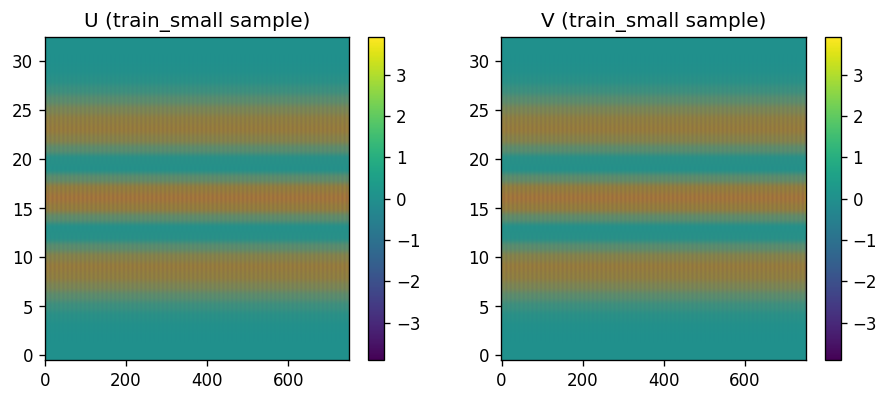


-- Tail metrics with threshold |u|>|5.0| --
[train_small] final: U=0.00% V=0.00% | last10%: U=0.00% V=0.00%
[val_small] final: U=0.00% V=0.00% | last10%: U=0.00% V=0.00%
[test_small] final: U=0.00% V=0.00% | last10%: U=0.00% V=0.00%

-- Tail metrics with threshold |u|>|3.0| --
[train_small] final: U=27.27% V=27.27% | last10%: U=27.27% V=27.27%
[val_small] final: U=27.27% V=27.27% | last10%: U=27.27% V=27.27%
[test_small] final: U=27.27% V=27.27% | last10%: U=27.27% V=27.27%


In [25]:
# === Cell 5 (revised): Dataset integrity + saturation-aware checks ===
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

def dataset_check(npz_path):
    print("[CHECK] Loading:", npz_path)
    z = np.load(npz_path, allow_pickle=True)
    U,V,W1,W2,J1,J2,P = z["U"],z["V"],z["W1"],z["W2"],z["J1"],z["J2"],z["P"]
    x,t = z["x"],z["t"]
    meta = z["meta"].item() if "meta" in z.files else {}
    clip_val = meta.get("clip_val", float("nan"))
    print("  shapes  U",U.shape," V",V.shape," P",P.shape," x",x.shape," t",t.shape)
    dt = np.diff(t)
    print(f"  grid    t[0]={t[0]:.3g}, t[-1]={t[-1]:.3g}, mean dt≈{dt.mean():.3g}")
    dx_min = float(np.min(np.diff(np.sort(x))))
    print(f"  x in [{x.min():.6g},{x.max():.6g}], min Δx≈{dx_min:.8f}")
    for nm, A in [("U",U),("V",V),("W1",W1),("W2",W2),("J1",J1),("J2",J2)]:
        ok = np.isfinite(A).all()
        print(f"  finite {nm}? {ok}")
    print("  meta:", meta)
    return z

def quick_range_check(z, name):
    U,V,P = z["U"], z["V"], z["P"]
    meta = z["meta"].item() if "meta" in z.files else {}
    clip_val = meta.get("clip_val", float("nan"))
    for nm, A in [("U",U),("V",V)]:
        print(f"[{name}] {nm}: mean={A.mean():.4g} std={A.std():.4g} "
              f"min={A.min():.4g} max={A.max():.4g} finite={np.isfinite(A).all()}")
    print(f"[{name}] P: mean={P.mean():.4g} std={P.std():.4g} finite={np.isfinite(P).all()}")
    print(f"[{name}] clip_val in meta: {clip_val}")

def fraction_outside(A, lo=-5.0, hi=5.0):
    n = A.size
    return float(((A<=lo) | (A>=hi)).sum()) / n

def fraction_at_clip(A, clip_val):
    if not np.isfinite(clip_val):
        return np.nan
    n = A.size
    return float(((A <= -clip_val) | (A >= clip_val)).sum()) / n

# --- Check the small splits you actually generated ---
z_tr = dataset_check(Path("data_spde")/"spde_train_small.npz")
z_va = dataset_check(Path("data_spde")/"spde_val_small.npz")
z_te = dataset_check(Path("data_spde")/"spde_test_small.npz")

print()
quick_range_check(z_tr,"train_small")
quick_range_check(z_va,"val_small")
quick_range_check(z_te,"test_small")

# Compute “soft-tail%” (outside ±5) and true “saturation%” (exactly at ±clip_val)
def report_tails_and_saturation(z, name, soft_range=5.0):
    meta = z["meta"].item() if "meta" in z.files else {}
    clip_val = meta.get("clip_val", float("nan"))
    U,V = z["U"], z["V"]
    softU = 100 * fraction_outside(U, -soft_range, +soft_range)
    softV = 100 * fraction_outside(V, -soft_range, +soft_range)
    satU  = 100 * fraction_at_clip(U, clip_val)
    satV  = 100 * fraction_at_clip(V, clip_val)
    print(f"[{name}] soft-tail% (>|{soft_range}|): U={softU:.2f}%  V={softV:.2f}%")
    print(f"[{name}] saturation@±clip_val ({clip_val}): U={satU:.2f}%  V={satV:.2f}%")

print()
report_tails_and_saturation(z_tr,"train_small")
report_tails_and_saturation(z_va,"val_small")
report_tails_and_saturation(z_te,"test_small")

# Quick visual (one random sample from train_small)
k = np.random.randint(z_tr["U"].shape[0])
fig, axs = plt.subplots(1,2, figsize=(9,3.5))
im0 = axs[0].imshow(z_tr["U"][k].T, aspect='auto', origin='lower'); axs[0].set_title("U (train_small sample)")
im1 = axs[1].imshow(z_tr["V"][k].T, aspect='auto', origin='lower'); axs[1].set_title("V (train_small sample)")
plt.colorbar(im0, ax=axs[0]); plt.colorbar(im1, ax=axs[1]); plt.show()

# --- Windowed tail % over the last 10% of time steps ---
# --- Final-time tail % (avoids counting early transients) ---
def tail_pct_final(z, thr=5.0):
    """Compute % of gridpoints above |thr| at the final time slice only."""
    U_last = z["U"][:, -1]  # shape (B, X)
    V_last = z["V"][:, -1]
    tU = 100.0 * (np.abs(U_last) > thr).sum() / U_last.size
    tV = 100.0 * (np.abs(V_last) > thr).sum() / V_last.size
    return tU, tV

# for split in ["train_small", "val_small", "test_small"]:
#     z = np.load(f"data_spde/spde_{split}.npz", allow_pickle=True)
#     tU, tV = tail_pct_final(z, thr=5.0)
#     print(f"[{split}] final-time tail% (>|5|): U={tU:.2f}%  V={tV:.2f}%")

for thr in [5.0, 3.0]:
    print(f"\n-- Tail metrics with threshold |u|>|{thr}| --")
    for split in ["train_small","val_small","test_small"]:
        z = np.load(f"data_spde/spde_{split}.npz", allow_pickle=True)
        tU_f, tV_f = tail_pct_final(z, thr=thr)
        tU_w, tV_w = tail_pct_last_window(z, thr=thr, frac=0.10)
        print(f"[{split}] final: U={tU_f:.2f}% V={tV_f:.2f}% | last10%: U={tU_w:.2f}% V={tV_w:.2f}%")






=== _probe ===
[CHECK] Loading: data_spde/_probe.npz
  shapes  U (4, 201, 33)  V (4, 201, 33)  P (4, 10)  x (33,)  t (201,)
  grid    t[0]=0, t[-1]=0.4, mean dt≈0.002
  x in [-1,1], min Δx≈0.00481527
  finite U? True
  finite V? True
  finite W1? True
  finite W2? True
  finite J1? True
  finite J2? True
  params columns = [a_E, sigma_E, d_E, b, sigma_u, sigma_v, lambda_jump_u, lambda_jump_v, jump_scale_u, jump_scale_v]
[probe] U: mean=-722.6 std=9.95e+08 min=-1e+09 max=1e+09 finite=True
[probe] V: mean=-2.488e+06 std=9.95e+08 min=-1e+09 max=1e+09 finite=True
[probe] P: mean=0.5249 std=0.6331 finite=True
[probe] clip% U=99.0050%  V=99.0050%


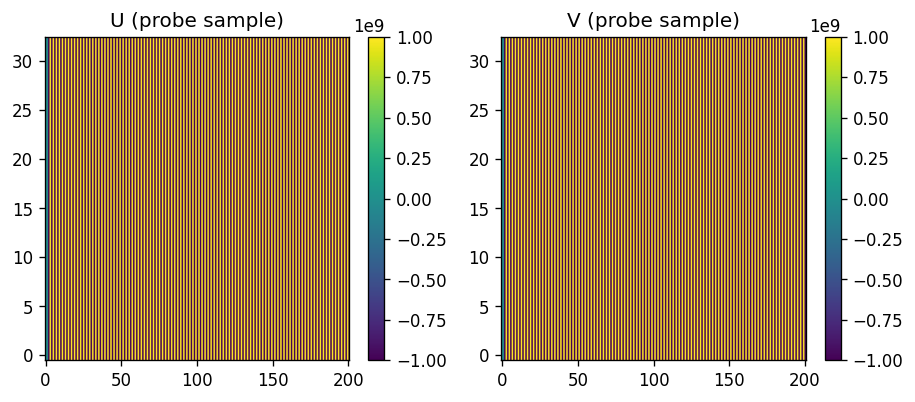

In [35]:
# === Cell 6: from cell 5 Probe check: confirm no-clip behavior ===

print("\n=== _probe ===")
_ = dataset_check(Path("data_spde")/"_probe.npz")

z_pr = np.load("data_spde/_probe.npz", allow_pickle=True)
quick_range_check(z_pr, "probe")

def clip_fraction(A, lo=-1e9, hi=1e9):
    n = A.size
    return float(((A<=lo) | (A>=hi)).sum()) / n

print(f"[probe] clip% U={100*clip_fraction(z_pr['U']):.4f}%  V={100*clip_fraction(z_pr['V']):.4f}%")

# quick visualization of a probe sample
import matplotlib.pyplot as plt
k = np.random.randint(z_pr["U"].shape[0])
fig, axs = plt.subplots(1,2, figsize=(9,3.5))
im0 = axs[0].imshow(z_pr["U"][k].T, aspect='auto', origin='lower'); axs[0].set_title("U (probe sample)")
im1 = axs[1].imshow(z_pr["V"][k].T, aspect='auto', origin='lower'); axs[1].set_title("V (probe sample)")
plt.colorbar(im0, ax=axs[0]); plt.colorbar(im1, ax=axs[1])
plt.show()


In [ ]:
# === Cell 7: Split consistency check ===
import numpy as np, json
from pathlib import Path

def read_meta(npz_path):
    z = np.load(npz_path, allow_pickle=True)
    meta = z["meta"].item() if isinstance(z["meta"].item(), dict) else dict(z["meta"].item())
    shapes = {k: z[k].shape for k in ["U","V","W1","W2","J1","J2","P","x","t"]}
    return meta, shapes

for p in ["data_spde/spde_train.npz",
          "data_spde/spde_val.npz",
          "data_spde/spde_test.npz"]:
    m, s = read_meta(p)
    print("\n==", p, "==")
    print("meta:", m)
    print("shapes:", s)

print("\n[Cell 7] Split consistency check done.")



== data_spde/spde_train.npz ==
meta: {'version': 'v1.1-imex-cheb-neumann', 'N': 32, 'T': 0.4, 'dt': 0.002, 'seed': 10, 'clip_val': 5.0, 'bc': 'Neumann', 'space': 'Chebyshev-Lobatto', 'scheme': 'IMEX (diff implicit, react explicit)'}
shapes: {'U': (400, 201, 33), 'V': (400, 201, 33), 'W1': (400, 201, 33), 'W2': (400, 201, 33), 'J1': (400, 201, 33), 'J2': (400, 201, 33), 'P': (400, 10), 'x': (33,), 't': (201,)}

== data_spde/spde_val.npz ==
meta: {'version': 'v1.1-imex-cheb-neumann', 'N': 32, 'T': 0.4, 'dt': 0.002, 'seed': 20, 'clip_val': 5.0, 'bc': 'Neumann', 'space': 'Chebyshev-Lobatto', 'scheme': 'IMEX (diff implicit, react explicit)'}
shapes: {'U': (48, 201, 33), 'V': (48, 201, 33), 'W1': (48, 201, 33), 'W2': (48, 201, 33), 'J1': (48, 201, 33), 'J2': (48, 201, 33), 'P': (48, 10), 'x': (33,), 't': (201,)}

== data_spde/spde_test.npz ==
meta: {'version': 'v1.1-imex-cheb-neumann', 'N': 32, 'T': 0.4, 'dt': 0.002, 'seed': 30, 'clip_val': 5.0, 'bc': 'Neumann', 'space': 'Chebyshev-Lobatto'

In [ ]:
# === Cell 8: Distribution sanity (params & fields across splits) ===
import numpy as np

def summary(z):
    out = {}
    out["P_mean"] = z["P"].mean(axis=0)
    out["P_std"]  = z["P"].std(axis=0)
    out["U_mean"] = z["U"].mean()
    out["U_std"]  = z["U"].std()
    out["V_mean"] = z["V"].mean()
    out["V_std"]  = z["V"].std()
    return out

paths = {
    "train": "data_spde/spde_train.npz",
    "val":   "data_spde/spde_val.npz",
    "test":  "data_spde/spde_test.npz",
}

S = {}
for k,p in paths.items():
    z = np.load(p, allow_pickle=True)
    S[k] = summary(z)

print("Param means (train/val/test) per column [a_E, sigma_E, d_E, b, sigma_u, sigma_v, lambda_jump_u, lambda_jump_v, jump_scale_u, jump_scale_v]:")
for k in ["train","val","test"]:
    print(k, np.round(S[k]["P_mean"], 4))

print("\nParam stds:")
for k in ["train","val","test"]:
    print(k, np.round(S[k]["P_std"], 4))

print("\nField global stats (U/V):")
for k in ["train","val","test"]:
    print(k, "U(mean,std)=", round(S[k]["U_mean"],4), round(S[k]["U_std"],4),
              "| V(mean,std)=", round(S[k]["V_mean"],4), round(S[k]["V_std"],4))
print("\n[Cell 8] Distribution sanity check done.")


Param means (train/val/test) per column [a_E, sigma_E, d_E, b, sigma_u, sigma_v, lambda_jump_u, lambda_jump_v, jump_scale_u, jump_scale_v]:
train [0.9962 0.5788 1.2544 1.9937 0.0664 0.0653 0.1342 0.1894 0.0666 0.0266]
val [0.956  0.5814 1.2471 2.0126 0.0675 0.0666 0.1375 0.1922 0.066  0.0265]
test [0.9892 0.5825 1.2626 2.012  0.0655 0.064  0.1359 0.1869 0.0667 0.0282]

Param stds:
train [0.2133 0.0581 0.1228 0.1971 0.013  0.0117 0.0112 0.03   0.0121 0.0127]
val [0.178  0.0594 0.1189 0.2171 0.0136 0.0147 0.0122 0.0303 0.0126 0.0126]
test [0.1632 0.071  0.1413 0.2194 0.0133 0.0109 0.0114 0.0401 0.0123 0.0124]

Field global stats (U/V):
train U(mean,std)= 2.8839 3.9486 | V(mean,std)= 0.6782 4.8267
val U(mean,std)= 2.7037 4.0698 | V(mean,std)= 0.969 4.7752
test U(mean,std)= 2.579 4.1539 | V(mean,std)= 0.9965 4.765

[Cell 4c] Distribution sanity check done.


In [ ]:

# === Cell 9: DeepONet Dataset (cumulative-noise features + late-time bias) ===
def fourier_feats(arr, K):
    arr = arr.reshape(-1)
    outs=[arr[:,None]]
    for k in range(1, K+1):
        outs += [np.sin(np.pi*k*arr)[:,None], np.cos(np.pi*k*arr)[:,None]]
    return np.concatenate(outs, axis=1)

class SPDEDatasetDeepONet(Dataset):
    def __init__(self, npz_path, kx=8, kt=8, points_per_sample=4096, seed=123, residual=True):
        rng = np.random.default_rng(seed)
        z = np.load(npz_path, allow_pickle=True)
        self.x, self.t = z["x"], z["t"]
        self.U, self.V = z["U"], z["V"]
        self.W1, self.W2, self.J1, self.J2 = z["W1"], z["W2"], z["J1"], z["J2"]
        self.P = z["P"]

        self.B, self.T, self.X = self.U.shape
        self.residual = residual
        self.kx, self.kt = kx, kt

        self.u_mean, self.u_std = self.U.mean(), self.U.std()+1e-6
        self.v_mean, self.v_std = self.V.mean(), self.V.std()+1e-6
        self.P_mean = self.P.mean(axis=0, keepdims=True)
        self.P_std  = self.P.std(axis=0, keepdims=True) + 1e-9
        Pn = (self.P - self.P_mean)/self.P_std

        Fx = fourier_feats(self.x, kx)
        t01=(self.t - self.t.min())/(self.t.max()-self.t.min()); tbar = 2*t01-1.0
        Ft = fourier_feats(tbar, kt)

        beta = 1.5; mix_unif = 0.45
        t_idx = np.arange(self.T)
        w = (t_idx / max(1, self.T-1)) ** beta
        w = w / (w.sum() + 1e-12)
        w = (1.0 - mix_unif)*w + mix_unif*(np.ones_like(w)/self.T)
        self._time_pmf = w.astype(np.float64)

        def zscore(a): m=a.mean(); s=a.std()+1e-9; return (a-m)/s
        W1c = zscore(np.cumsum(self.W1, axis=1))
        W2c = zscore(np.cumsum(self.W2, axis=1))
        J1c = zscore(np.cumsum(self.J1, axis=1))
        J2c = zscore(np.cumsum(self.J2, axis=1))

        branch_list, trunk_list, y_list = [], [], []
        for i in range(self.B):
            U0 = (self.U[i,0] - self.u_mean)/self.u_std
            V0 = (self.V[i,0] - self.v_mean)/self.v_std
            branch_i = np.concatenate([U0, V0, Pn[i]], axis=0)

            xi = rng.integers(0, self.X, size=points_per_sample)
            ti = rng.choice(self.T, size=points_per_sample, replace=True, p=self._time_pmf)

            trunk_xy = np.concatenate([Fx[xi], Ft[ti]], axis=1)
            noise_at = np.stack([W1c[i,ti,xi], W2c[i,ti,xi], J1c[i,ti,xi], J2c[i,ti,xi]], axis=1)
            trunk = np.concatenate([trunk_xy, noise_at], axis=1)

            U_norm = (self.U[i,ti,xi] - self.u_mean)/self.u_std
            V_norm = (self.V[i,ti,xi] - self.v_mean)/self.v_std
            if residual:
                U0s = (self.U[i,0,xi] - self.u_mean)/self.u_std
                V0s = (self.V[i,0,xi] - self.v_mean)/self.v_std
                ys  = np.stack([U_norm - U0s, V_norm - V0s], axis=1)
            else:
                ys  = np.stack([U_norm, V_norm], axis=1)

            branch_list.append(np.tile(branch_i[None,:], (points_per_sample,1)))
            trunk_list.append(trunk)
            y_list.append(ys)

        self.branch = torch.from_numpy(np.vstack(branch_list)).float()
        self.trunk  = torch.from_numpy(np.vstack(trunk_list)).float()
        self.y      = torch.from_numpy(np.vstack(y_list)).float()

    def __len__(self): return self.y.shape[0]
    def __getitem__(self, idx): return self.branch[idx], self.trunk[idx], self.y[idx]

KX, KT = 8, 8
ds_tmp = SPDEDatasetDeepONet(Path("data_spde")/"spde_train.npz", kx=KX, kt=KT, points_per_sample=4096, residual=True)
print("DeepONet dims — branch:", ds_tmp.branch.shape[1], "trunk:", ds_tmp.trunk.shape[1])


DeepONet dims — branch: 76 trunk: 38


In [ ]:
# === Cell 10: DeepONet model + trainer (updated: early-stop + LR print; no verbose arg) ===
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

def _get_lr(optimizer):
    for pg in optimizer.param_groups:
        return pg.get("lr", None)

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, width=256, depth=4, act=nn.SiLU, p_drop=0.15):
        super().__init__()
        layers=[nn.Linear(in_dim, width), act(), nn.Dropout(p_drop)]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), act(), nn.Dropout(p_drop)]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

class DeepONet(nn.Module):
    def __init__(self, branch_in, trunk_in, width=256, depth=4, p_drop=0.15):
        super().__init__()
        self.branch_net = MLP(branch_in, width, width=width, depth=depth, act=nn.SiLU, p_drop=p_drop)
        self.trunk_net  = MLP(trunk_in,  width, width=width, depth=depth, act=nn.SiLU, p_drop=p_drop)
        self.head = nn.Sequential(
            nn.Linear(2*width, width), nn.SiLU(), nn.Dropout(p_drop), nn.Linear(width, 2)
        )
    def forward(self, branch, trunk):
        return self.head(torch.cat([self.branch_net(branch), self.trunk_net(trunk)], dim=-1))

def rel_l2_pointwise(pred, tgt):
    num = torch.sum((pred - tgt)**2)
    den = torch.sum(tgt**2) + 1e-12
    return torch.sqrt(num/den).item()

def train_deeponet(train_path, val_path, test_path,
                   kx=8, kt=8, points_per_sample=4096,
                   width=384, depth=5, batch=36, epochs=200, lr=3e-4, weight_decay=1e-4, seed=0):
    torch.manual_seed(seed); np.random.seed(seed)

    # ds_tr = SPDEDatasetDeepONet(train_path, kx=kx, kt=kt, points_per_sample=points_per_sample, residual=True)
    # ds_va = SPDEDatasetDeepONet(val_path,   kx=kx, kt=kt, points_per_sample=points_per_sample//2, residual=True)

    ds_tr = SPDEDatasetDeepONet(train_path, kx=kx, kt=kt, points_per_sample=points_per_sample, residual=True)

    # --- NEW ---
    stats = dict(
        u_mean=ds_tr.u_mean, u_std=ds_tr.u_std,
        v_mean=ds_tr.v_mean, v_std=ds_tr.v_std,
        P_mean=ds_tr.P_mean, P_std=ds_tr.P_std
    )

    ds_va = SPDEDatasetDeepONet(val_path,   kx=kx, kt=kt, points_per_sample=points_per_sample//2,
                                residual=True, norm_stats=stats)


    expected_trunk  = (1 + 2*kx) + (1 + 2*kt) + 4
    expected_branch = 2 * ds_tr.X + 10
    print(f"[train] branch_dim = {ds_tr.branch.shape[1]}  |  trunk_dim = {ds_tr.trunk.shape[1]}")
    print(f"        expected_branch = {2*ds_tr.X + 10}     expected_trunk = {expected_trunk}")
    print(f"[val]   branch_dim = {ds_va.branch.shape[1]}  |  trunk_dim = {ds_va.trunk.shape[1]}")
    print(f"        expected_branch = {2*ds_va.X + 10}     expected_trunk = {expected_trunk}")

    pin = (DEVICE.type=="cuda")
    tr_loader = DataLoader(ds_tr, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=pin)
    va_loader = DataLoader(ds_va, batch_size=batch, shuffle=False, num_workers=2, pin_memory=pin)

    model = DeepONet(branch_in=ds_tr.branch.shape[1], trunk_in=ds_tr.trunk.shape[1],
                     width=width, depth=depth).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    #sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=25)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5,
                      threshold=1e-3, threshold_mode='rel', cooldown=3, min_lr=1e-5)

    loss_fn = nn.HuberLoss(delta=0.5)

    # Early-stop bookkeeping
    best_val = float("inf")
    patience, bad = 50, 0
    best_state = None

    train_losses, val_losses = [], []
    print(f"[INFO] Device: {DEVICE}  |  pin_memory={pin}")
    for ep in range(1, epochs+1):
        model.train(); tl=0.0; nb=0
        for b,tr,y in tr_loader:
            b,tr,y = b.to(DEVICE), tr.to(DEVICE), y.to(DEVICE)
            pred = model(b,tr); loss = loss_fn(pred,y)
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            tl += loss.item(); nb += 1
        train_losses.append(tl/nb if nb>0 else float("nan"))

        model.eval(); vl=0.0; nbv=0
        with torch.no_grad():
            for b,tr,y in va_loader:
                b,tr,y = b.to(DEVICE), tr.to(DEVICE), y.to(DEVICE)
                pred = model(b,tr); vl += loss_fn(pred,y).item(); nbv += 1
        val_losses.append(vl/nbv if nbv>0 else float("nan"))

        # Step scheduler (no verbose arg in this torch)
        sched.step(val_losses[-1])
        if ep == 1 or (len(val_losses) >= 2 and val_losses[-1] > val_losses[-2] + 1e-8):
            print(f"[DeepONet] plateau step — lr now {_get_lr(opt):.2e}")

        # Early-stop update
        if val_losses[-1] < best_val - 1e-5:
            best_val = val_losses[-1]; bad = 0
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            bad += 1

        if ep%10==0 or ep==1:
            print(f"[DeepONet] ep {ep:03d}/{epochs} | train {train_losses[-1]:.4e} | val {val_losses[-1]:.4e}")

        if bad >= patience:
            print(f"[DeepONet] Early stop at epoch {ep} (best val={best_val:.4e})")
            break

    # Restore best weights (if any)
    if best_state is not None:
        model.load_state_dict(best_state)

    plt.figure(figsize=(5,3))
    plt.plot(train_losses, label="train"); plt.plot(val_losses, label="val")
    plt.xlabel("epoch"); plt.ylabel("MSE (Huber)"); plt.legend(); plt.grid(True, alpha=.3)
    plt.title("DeepONet training")
    plt.savefig(Path("figures")/"deeponet_training_curve.pdf"); plt.show()



    # Test rel-L2
    ds_te = SPDEDatasetDeepONet(test_path, kx=kx, kt=kt, points_per_sample=points_per_sample//2,
                            residual=True, norm_stats=stats)   # <— add norm_stats
    #ds_te = SPDEDatasetDeepONet(test_path, kx=kx, kt=kt, points_per_sample=points_per_sample//2, residual=True)
    te_loader = DataLoader(ds_te, batch_size=batch, shuffle=False, num_workers=2, pin_memory=pin)
    reld = []
    with torch.no_grad():
        for b,tr,y in te_loader:
            b,tr,y = b.to(DEVICE), tr.to(DEVICE), y.to(DEVICE)
            pred = model(b,tr); reld.append(rel_l2_pointwise(pred,y))
    rel_mean, rel_std = float(np.mean(reld)), float(np.std(reld))

    plt.figure(figsize=(4,3))
    plt.hist(reld, bins=30, density=True); plt.grid(True, alpha=.3)
    plt.title(f"DeepONet rel-L2 (test) mean={rel_mean:.3f}")
    plt.savefig(Path("figures")/"deeponet_test_relL2_hist.pdf"); plt.show()

    return model, {"train_final": train_losses[-1], "val_final": val_losses[-1],
                   "test_relL2_mean": rel_mean, "test_relL2_std": rel_std}


In [ ]:
# === Cell 11: FNO spectral block (AMP/FFT safe) ===
import torch
import torch.nn as nn

class SpectralConv2d(nn.Module):
    """
    2D spectral convolution on (time, space).
    Input:  x  of shape (B, C_in, T, X)  [real]
    Output: y  of shape (B, C_out, T, X) [real]
    Keeps lowest `modes1` time modes and `modes2` spatial modes.
    """
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # time modes
        self.modes2 = modes2  # space modes
        # complex64 weights: (C_in, C_out, t_modes, k_modes)
        self.weights1 = nn.Parameter(
            0.02 * torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat)
        )

    def forward(self, x):
        """
        x: (B, C_in, T, X) real
        returns: (B, C_out, T, X) real
        """
        B, C_in, T, X = x.shape

        # ---- Upcast around FFT to avoid cuFFT half/bfloat16 restrictions ----
        in_dtype = x.dtype
        x32 = x if x.dtype == torch.float32 else x.to(torch.float32)

        # rfft2 over (T,X) → (B, C_in, T, K), K = X//2 + 1
        x_ft = torch.fft.rfft2(x32, norm='ortho')   # complex64
        K    = x_ft.shape[-1]

        # sanity checks
        assert x_ft.ndim == 4 and x_ft.shape[1] == C_in, \
            f"x_ft shape mismatch: got {tuple(x_ft.shape)}, expected (B,{C_in},T,K)"
        assert self.weights1.shape[:2] == (C_in, self.out_channels), \
            f"weights1 chan mismatch: got {tuple(self.weights1.shape[:2])}, expected ({C_in},{self.out_channels})"

        # allocate output spectrum (complex64): (B, C_out, T, K)
        out_ft = torch.zeros(B, self.out_channels, T, K,
                             device=x.device, dtype=torch.cfloat)

        t_modes = min(self.modes1, T)
        k_modes = min(self.modes2, K)

        # correct spectral multiply (contract C_in): (B,C_in,t,k) x (C_in,C_out,t,k) → (B,C_out,t,k)
        out_ft[:, :, :t_modes, :k_modes] = torch.einsum(
            "bctk,cotk->botk",
            x_ft[:, :, :t_modes, :k_modes],
            self.weights1[:, :, :t_modes, :k_modes]
        )

        # inverse FFT back to space-time grid, keep (T,X)
        y32 = torch.fft.irfft2(out_ft, s=(T, X), norm='ortho')  # float32 real
        y   = y32 if in_dtype == torch.float32 else y32.to(in_dtype)
        return y


In [ ]:
# === Cell 12: FNO Dataset (same .npz; cumulative-noise + normalized params) ===
class SPDEDatasetFNO(Dataset):
    def __init__(self, npz_path: str, norm_stats=None):   # <— add norm_stats
        z = np.load(npz_path, allow_pickle=True)

        self.x, self.t = z["x"], z["t"]
        self.U, self.V = z["U"], z["V"]
        self.W1, self.W2 = z["W1"], z["W2"]
        self.J1, self.J2 = z["J1"], z["J2"]
        self.P = z["P"]
        self.B, self.T, self.X = self.U.shape

        # ---- field & param stats (train or frozen) ----
        if norm_stats is None:
            self.u_mean, self.u_std = self.U.mean(), self.U.std() + 1e-6
            self.v_mean, self.v_std = self.V.mean(), self.V.std() + 1e-6
            self.P_mean = self.P.mean(axis=0, keepdims=True)
            self.P_std  = self.P.std(axis=0,  keepdims=True) + 1e-9
        else:
            self.u_mean = float(norm_stats["u_mean"]); self.u_std = float(norm_stats["u_std"])
            self.v_mean = float(norm_stats["v_mean"]); self.v_std = float(norm_stats["v_std"])
            self.P_mean = norm_stats["P_mean"];        self.P_std = norm_stats["P_std"]

        def zscore(a):
            m = a.mean(); s = a.std() + 1e-9
            return (a - m) / s

        self.W1c = zscore(np.cumsum(self.W1, axis=1))
        self.W2c = zscore(np.cumsum(self.W2, axis=1))
        self.J1c = zscore(np.cumsum(self.J1, axis=1))
        self.J2c = zscore(np.cumsum(self.J2, axis=1))


In [ ]:
# === CELL 13: FNO2d blocks + model (run this before the FNO trainer) ===
import torch
import torch.nn as nn
import torch.nn.functional as F

class FNO2dBlock(nn.Module):
    def __init__(self, width, modes_t, modes_x):
        super().__init__()
        self.width   = width
        self.modes_t = modes_t
        self.modes_x = modes_x
        self.spectral = SpectralConv2d(width, width, modes_t, modes_x)
        self.w = nn.Conv2d(width, width, kernel_size=1)
        self.act = nn.SiLU()

    def forward(self, x):
        # x: (B, C=width, T, X)
        y_spec = self.spectral(x)         # spectral conv → (B, width, T, X)
        y_skip = self.w(x)                # 1x1 skip
        y = self.act(y_spec + y_skip)
        return y

class FNO2d(nn.Module):
    """
    FNO over (time, space).
    Input:  (B, C_in,  T, X)
    Output: (B, C_out, T, X)
    """
    def __init__(self, in_channels, out_channels, width=64, modes_t=12, modes_x=16, layers=4):
        super().__init__()
        self.width   = width
        self.modes_t = modes_t
        self.modes_x = modes_x

        # Lift channel dim to 'width'
        self.lift = nn.Sequential(
            nn.Conv2d(in_channels, width, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(width, width, kernel_size=1),
        )

        # Stacked spectral blocks
        self.blocks = nn.ModuleList([
            FNO2dBlock(width, modes_t, modes_x) for _ in range(layers)
        ])

        # Project back to output channels
        self.proj = nn.Sequential(
            nn.Conv2d(width, width, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(width, out_channels, kernel_size=1),
        )

    def forward(self, x):
        # x: (B, C_in, T, X)
        z = self.lift(x)
        for blk in self.blocks:
            z = blk(z)
        y = self.proj(z)    # (B, C_out, T, X)
        return y


In [ ]:
# === Cell 14: Train FNO on same dataset (fixed) ===
def rel_l2_batch(pred, tgt):
    num = torch.sum((pred - tgt)**2, dim=(1,2,3))
    den = torch.sum(tgt**2, dim=(1,2,3)) + 1e-12
    return torch.sqrt(num/den)

def train_fno(train_path, val_path, test_path,
              width=128, modes_t=18, modes_x=16, layers=6,
              batch=4, epochs=200, lr=3e-4, weight_decay=1e-4,
              seed=0, patience=80):
    torch.manual_seed(seed); np.random.seed(seed)

    # Datasets / loaders
    ds_tr = SPDEDatasetFNO(train_path)
    # --- NEW: freeze normalization to train stats ---
    stats = dict(
        u_mean=ds_tr.u_mean, u_std=ds_tr.u_std,
        v_mean=ds_tr.v_mean, v_std=ds_tr.v_std,
        P_mean=ds_tr.P_mean, P_std=ds_tr.P_std)

    # Use train stats for val/test
    ds_va = SPDEDatasetFNO(val_path,  norm_stats=stats)
    ds_te = SPDEDatasetFNO(test_path, norm_stats=stats)
    # ds_va = SPDEDatasetFNO(val_path)
    # ds_te = SPDEDatasetFNO(test_path)

    print(f"[FNO] in_channels = 16 (u0,v0,W1c,W2c,J1c,J2c + 10 params)")
    print(f"[FNO] target_channels = 2 (u_residual, v_residual)")

    pin = (DEVICE.type=="cuda")
    tr_loader = DataLoader(ds_tr, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=pin)
    va_loader = DataLoader(ds_va, batch_size=batch, shuffle=False, num_workers=2, pin_memory=pin)
    te_loader = DataLoader(ds_te, batch_size=batch, shuffle=False, num_workers=2, pin_memory=pin)

    # Model / opt / sched / loss
    model = FNO2d(in_channels=16, out_channels=2, width=width,
                  modes_t=modes_t, modes_x=modes_x, layers=layers).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.6, patience=patience)
    loss_fn = nn.HuberLoss(delta=0.5)

    # Early stop trackers
    best_val = float("inf")
    bad = 0
    best_state = None

    tr_hist, va_hist = [], []
    print(f"[INFO] Device: {DEVICE}  |  pin_memory={pin}")
    for ep in range(1, epochs+1):
        # ---- train ----
        model.train(); tl=0.0; nb=0
        for x,y in tr_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            loss = loss_fn(pred,y)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item(); nb += 1
        tr_hist.append(tl/nb if nb>0 else float("nan"))

        # ---- val ----
        model.eval(); vl=0.0; nbv=0
        with torch.no_grad():
            for x,y in va_loader:
                x,y = x.to(DEVICE), y.to(DEVICE)
                pred = model(x)
                vl += loss_fn(pred,y).item(); nbv += 1
        va_hist.append(vl/nbv if nbv>0 else float("nan"))
        sched.step(va_hist[-1])

        # Early stop bookkeeping
        if va_hist[-1] < best_val - 1e-5:
            best_val = va_hist[-1]
            bad = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            bad += 1

        if ep % 5 == 0 or ep == 1:
            print(f"[FNO] ep {ep:03d}/{epochs} | train {tr_hist[-1]:.4e} | val {va_hist[-1]:.4e}")

        if bad >= patience:
            print(f"[FNO] Early stop at epoch {ep} (best val={best_val:.4e})")
            break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    # Curves
    plt.figure(figsize=(5,3))
    plt.plot(tr_hist, label="train"); plt.plot(va_hist, label="val")
    plt.xlabel("epoch"); plt.ylabel("MSE (Huber)"); plt.legend(); plt.grid(True, alpha=.3)
    plt.title("FNO training")
    plt.savefig(Path("figures")/"fno_training_curve.pdf"); plt.show()

    # Test rel-L2
    rel_all = []
    with torch.no_grad():
        for x,y in te_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            rel = rel_l2_batch(pred,y).cpu().numpy()
            rel_all.append(rel)
    rel_all = np.concatenate(rel_all)
    rel_mean, rel_std = float(rel_all.mean()), float(rel_all.std())

    plt.figure(figsize=(4,3))
    plt.hist(rel_all, bins=20, density=True); plt.grid(True, alpha=.3)
    plt.title(f"FNO rel-L2 (test) mean={rel_mean:.3f}")
    plt.savefig(Path("figures")/"fno_test_relL2_hist.pdf"); plt.show()

    # Quick recon plot (u-residual)
    x_te, y_te = next(iter(DataLoader(ds_te, batch_size=1, shuffle=True)))
    with torch.no_grad():
        pred = model(x_te.to(DEVICE)).cpu().numpy()[0]  # (2,T,X)
    tgt = y_te.numpy()[0]
    fig, axs = plt.subplots(1,2, figsize=(9,3.5))
    im0 = axs[0].imshow(tgt[0].T, aspect='auto', origin='lower'); axs[0].set_title("u residual true")
    im1 = axs[1].imshow(pred[0].T, aspect='auto', origin='lower'); axs[1].set_title("u residual pred")
    for ax in axs:
        ax.set_xlabel("t-step"); ax.set_ylabel("x-index")
    plt.colorbar(im0, ax=axs[0]); plt.colorbar(im1, ax=axs[1])
    plt.savefig(Path("figures")/"fno_recon_u.pdf"); plt.show()

    return model, {
        "train_final": tr_hist[-1],
        "val_final": va_hist[-1],
        "test_relL2_mean": rel_mean,
        "test_relL2_std": rel_std
    }


In [ ]:
# === Cell 15: Run DeepONet & FNO, summarize ===
train_p = str(Path("data_spde")/"spde_train.npz")
val_p   = str(Path("data_spde")/"spde_val.npz")
test_p  = str(Path("data_spde")/"spde_test.npz")

# DeepONet (set epochs to 100 if you want)
t0 = time.time()
deeponet_model, metrics_deeponet = train_deeponet(
    train_p, val_p, test_p,
    kx=8, kt=8,
    points_per_sample=4096,   # your new setting
    width=384, depth=5,
    batch=36,
    epochs=200,               # <-- here to make it 100
    lr=3e-4
)
t1 = time.time()

# FNO (no AMP arg; set epochs to 100 here too)
fno_model, metrics_fno = train_fno(
    train_p, val_p, test_p,
    width=128,
    modes_t=18,
    modes_x=16,
    layers=6,
    batch=4,
    epochs=200,               # <-- here to make it 100
    lr=3e-4
)
t2 = time.time()

print("\n=== Summary ===")
print("DeepONet:", metrics_deeponet, f"(time: {t1 - t0:.1f}s)")
print("FNO     :", metrics_fno,      f"(time: {t2 - t1:.1f}s)")

summary = {"DeepONet": metrics_deeponet, "FNO": metrics_fno}
with open(Path("figures")/"metrics_summary.json","w") as f:
    json.dump(summary, f, indent=2)
print("Saved summary to", Path("figures")/"metrics_summary.json")


[train] branch_dim = 76  |  trunk_dim = 38
        expected_branch = 76     expected_trunk = 38
[val]   branch_dim = 76  |  trunk_dim = 38
        expected_branch = 76     expected_trunk = 38
[INFO] Device: cuda  |  pin_memory=True
[DeepONet] plateau step — lr now 3.00e-04
[DeepONet] ep 001/200 | train 6.7387e-02 | val 2.9577e-01
[DeepONet] plateau step — lr now 3.00e-04


Exception in thread Thread-7 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/resource_s

KeyboardInterrupt: 


### Notes
- Both models are trained **on the same dataset** for apples-to-apples comparison.
- DeepONet uses **point sampling** with cumulative-noise and late-time bias (harder supervision).
- FNO ingests the full (t,x) grid, with input channels: `u0, v0, W1c, W2c, J1c, J2c, params(10)` and predicts residuals `[U-u0, V-v0]`.
- Plots in `figures/`: DeepONet & FNO curves, rel-L2 histograms, a quick reconstruction.
- Scale up later by increasing dataset sizes (Cell 3), DeepONet points_per_sample, or FNO width/modes.
